In [2]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import ultraplot as plot 
import seaborn as sns
import colorcet as cc

import uproot
import mplhep as hep
import hist
import hist.intervals
import hist.plot

plot.rc['figure.facecolor'] = 'none'
plot.rc['savefig.facecolor'] = 'none'
plot.rc['legend.frameon'] = False
plot.rc['axes.autolimit_mode'] = 'data'

In [3]:
loader_formatted = {
    'nominal': 'Nominal reconstruction',
    'cheated_2d': 'Injected clustering',
    'cheated_vtx': 'Injected vertex',
    'cheated_vtxSelection': 'Injected vertex selection',
    'cheated_3d': 'Injected 3D matching',
    'cheated_nuH': r'Injected $\nu$-hierarchy',
    'cheated_mva': 'Injected track-score',
    'cheated_2d_vtx': 'Injected clustering + vertex',
    'cheated_2d_vtx_3d': 'Injected clustering + vertex + 3D matching',
    'cheated_2d_vtx_3d_nu': r'Injected clustering + vertex + 3D matching + $\nu$-hierarchy',
    'cheated_2d_vtx_3d_nu_mva': r'Injected clustering + vertex + 3D matching + $\nu$-hierarchy + track-score'
}

In [4]:

class Analysis:
    def __init__(self, data, binning, tree_bases=['reco_true_{}', 'reco_{}', 'true_{}']):
        self.binning = binning
        self.data = data

        self.reco_true_base_string, self.reco_base_string, self.true_base_string = tree_bases

    def efficiency(self, tree_name: str, variable: str = 'true_E'):

        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        true = self.data[self.true_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.event, true.event, on='event')
        
        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.event.isin(common.event)][variable].values)
        true_H = hist.Hist(self.binning).fill(true[true.event.isin(common.event)][variable].values)

        reco_true_values = reco_true_H.values()
        true_values = true_H.values()
        
        with np.errstate(divide="ignore", invalid="ignore"):
            efficiency = reco_true_values/true_values
            efficiency_uncertainty = hist.intervals.ratio_uncertainty(
                reco_true_values, true_values, 'efficiency'
            )
        
        return efficiency, efficiency_uncertainty
    
    def purity(self, tree_name: str, variable: str = 'true_E'):
        
        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        reco = self.data[self.reco_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.event, reco.event, on='event')
        
        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.event.isin(common.event)][variable].values)
        reco_H = hist.Hist(self.binning).fill(reco[reco.event.isin(common.event)][variable].values)

        reco_true_values = reco_true_H.values()
        reco_values = reco_H.values()
        
        with np.errstate(divide="ignore", invalid="ignore"):
            purity = reco_true_values/reco_values
            purity_uncertainty = hist.intervals.ratio_uncertainty(
                reco_true_values, reco_values, 'efficiency'
            )
        
        return purity, purity_uncertainty

    def spectra(self, tree_name: str, variable: str = 'true_E'):
        
        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        reco = self.data[self.reco_base_string.format(tree_name)].arrays(library='pd')
        true = self.data[self.true_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.event, reco.event, on='event')
        common = pd.merge(common.event, true.event, on='event')

        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.event.isin(common.event)][variable].values)
        reco_H = hist.Hist(self.binning).fill(reco[reco.event.isin(common.event)][variable].values)
        true_H = hist.Hist(self.binning).fill(true[true.event.isin(common.event)][variable].values)

        return reco_true_H, reco_H, true_H

class Component:
    def __init__(self, data, tree_base='{}'):
        self.data = data
        self.tree_base = tree_base

    def get(self, 
            stage1: str | list[str], 
            product: str | list[str], 
            binning, 
            product_thr: float | list[float] = -100,
            conditions: dict | None = None
           ):

        if not isinstance(stage1, list):
            stage1 = [stage1]

        if not isinstance(product, list):
            product = [product]

        if not isinstance(product_thr, list):
            product_thr = [product_thr] * len(product)
        

        if not isinstance(binning, list) and len(product) > 1:
            binning = [binning] * len(product)
        
        data = []
        hists = []
    
        for e in stage1:
            data.append(self.data[self.tree_base.format(e)].arrays(library='pd'))

        
        d0 = data[0]
        common = d0
        for i in range(1, len(data)):
            d = data[i]
            common = pd.merge(
                d0[(d0[product] > product_thr).all(axis=1)][['Evt', *product]], 
                d[(d[product] > product_thr).all(axis=1)][['Evt', *product]], 
                on='Evt', suffixes=('', '_more')
            )
            # print(common.keys())
            d0 = common

        return_data = []
        for d in data:
            if len(product) == 1:
                if conditions is not None:
                    for k in conditions:
                        d = d[d[k] == conditions[k]]
                hists.append(hist.Hist(binning).fill(d[d.Evt.isin(common.Evt)][product[0]].fillna(0).values))
            else:
                fill_data = [d[d.Evt.isin(common.Evt)][p].values for p in product]
                hists.append(hist.Hist(*binning).fill(*fill_data))
                return_data.append(d[d.Evt.isin(common.Evt)][['Evt', *product]])
            if False:
                print('ERROR: only 1D and 2D histograms are supported. The provided list of products exceed dimensionality: {}'.format(product))
            
        return hists, return_data
            
    def keys(self, stage1):
        return self.data[self.tree_base.format(stage1)].keys()


In [5]:
CCNp_muonAna = Component(data=uproot.open('CCNp_particleAna.root:muons'), tree_base='true_{}')
CCNp_protonAna = Component(data=uproot.open('CCNp_particleAna.root:protons'), tree_base='true_{}')

CCNp_muonAna.keys('nominal'), CCNp_protonAna.keys('nominal')

(['event',
  'chi2_mu',
  'chi2_proton',
  'length',
  'length_ratio',
  'vtxDist',
  'trackScore',
  'completeness',
  'purity',
  'pandoraPrimary',
  'Run',
  'Subrun',
  'Evt'],
 ['chi2_mu',
  'chi2_proton',
  'length',
  'length_ratio',
  'vtxDist',
  'trackScore',
  'completeness',
  'purity',
  'depEnergy',
  'pandoraPrimary',
  'Run',
  'Subrun',
  'Evt'])

# Vertex improvement, from the cuts

The vertex increase by a factor of 7%, why is that? 
Looking at the variables of the selection
1. µID improves by 5%
2. pID improves by 8% (+1% wrt µID, so still interesting)
3. gamma not much different...





## Hit completeness/purity

In [6]:

binning=hist.axis.Regular(55, 0, 1, flow=False)
fig, ax = plot.subplots(
    width=5.5, height=6.5, ncols=1, nrows=2, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xlabel='Hit completeness',
    abc='a.', 
    yscale='log'
)
var='completeness'

(A,B,C), _ = CCNp_muonAna.get(['nominal', 'cheated_vtx', 'cheated_vtxSelection'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_vtx', var, binning)
C0, _ = CCNp_muonAna.get('cheated_vtxSelection', var, binning)

hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=loader_formatted['nominal'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=loader_formatted['cheated_vtx'])
hep.histplot(C0, yerr=False, ax=ax[0], color='red9', lw=1, ls=':', label=loader_formatted['cheated_vtxSelection'])
ax[0].format(urtitle='Muons')

(A,B,C), _ = CCNp_protonAna.get(['nominal', 'cheated_vtx', 'cheated_vtxSelection'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_vtx', var, binning)
C0, _ = CCNp_protonAna.get('cheated_vtxSelection', var, binning)
hep.histplot(A0, ax=ax[1], color='teal2', histtype='errorbar', label=loader_formatted['nominal'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[1], color='teal5', lw=3, label=loader_formatted['cheated_vtx'])
hep.histplot(C0, yerr=False, ax=ax[1], color='teal9', lw=1, ls=':', label=loader_formatted['cheated_vtxSelection'])
ax[1].format(urtitle='Protons')

[axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
[axi.legend(ncols=1) for axi in ax]


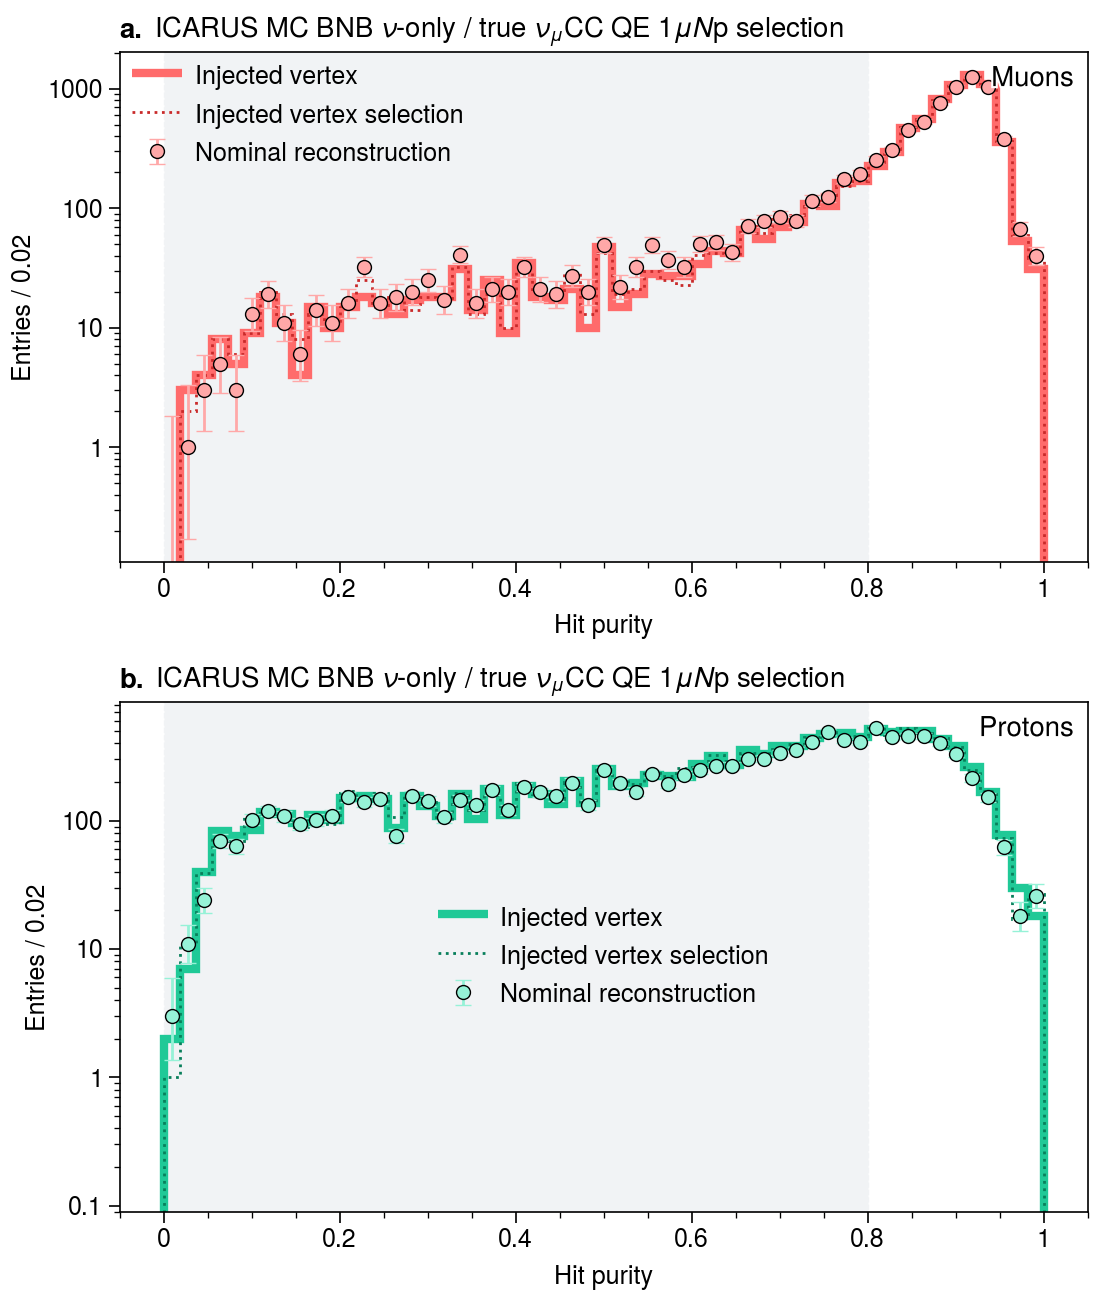

In [7]:

binning=hist.axis.Regular(55, 0, 1, flow=False)
fig, ax = plot.subplots(
    width=5.5, height=6.5, ncols=1, nrows=2, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xlabel='Hit purity',
    abc='a.', 
    yscale='log'
)

var='purity'

(A,B,C), _ = CCNp_muonAna.get(['nominal', 'cheated_vtx', 'cheated_vtxSelection'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_vtx', var, binning)
C0, _ = CCNp_muonAna.get('cheated_vtxSelection', var, binning)

hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=loader_formatted['nominal'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=loader_formatted['cheated_vtx'])
hep.histplot(C0, yerr=False, ax=ax[0], color='red9', lw=1, ls=':', label=loader_formatted['cheated_vtxSelection'])
ax[0].format(urtitle='Muons')

(A,B,C), _ = CCNp_protonAna.get(['nominal', 'cheated_vtx', 'cheated_vtxSelection'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_vtx', var, binning)
C0, _ = CCNp_protonAna.get('cheated_vtxSelection', var, binning)
hep.histplot(A0, ax=ax[1], color='teal2', histtype='errorbar', label=loader_formatted['nominal'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[1], color='teal5', lw=3, label=loader_formatted['cheated_vtx'])
hep.histplot(C0, yerr=False, ax=ax[1], color='teal9', lw=1, ls=':', label=loader_formatted['cheated_vtxSelection'])
ax[1].format(urtitle='Protons')


[axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
[axi.legend(ncols=1) for axi in ax]

## $\chi^2$ selection variables
The muons selction requires 
- $\chi^2_\mu < 30$
- $\chi^2_p > 60$

The protons selection 
- $\chi^2_p < 100$

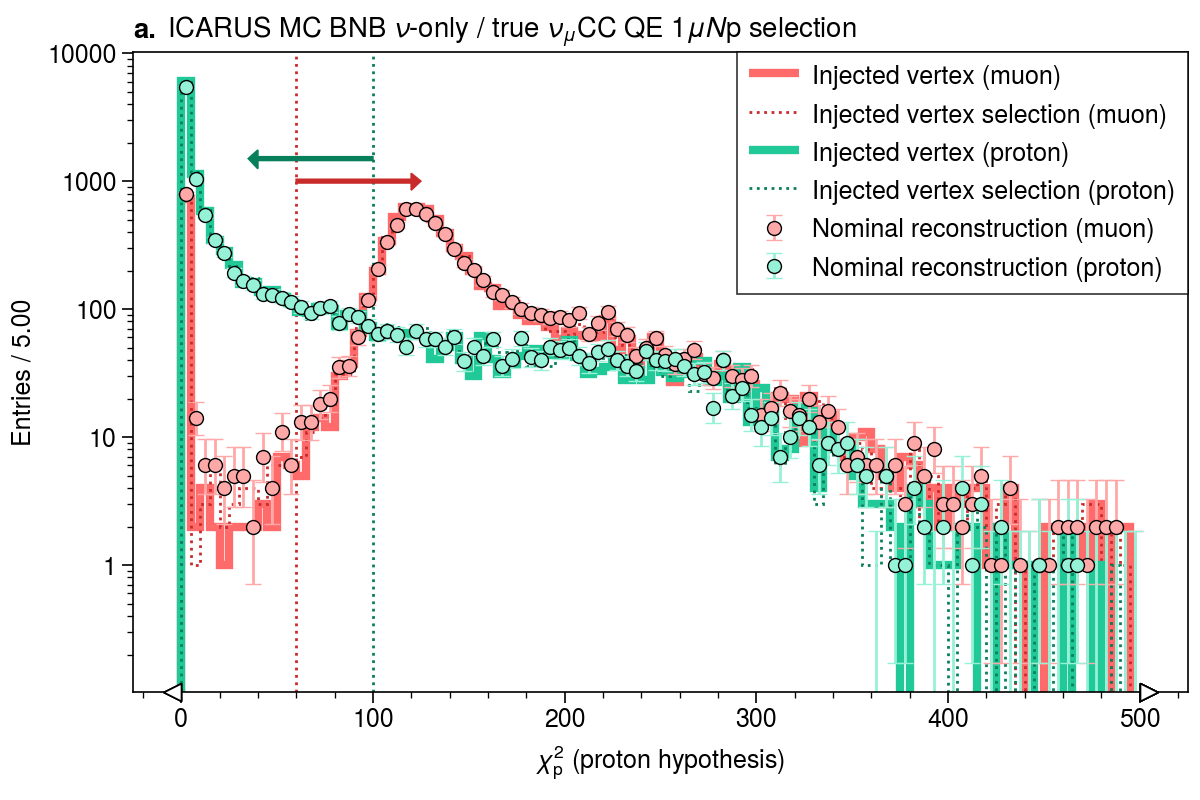

In [8]:

var='chi2_proton'
binning=hist.axis.Regular(100, 0, 500)

fig, ax = plot.subplots(
    width=6, height=4, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'$\chi^2_\mathrm{p}$ (proton hypothesis)',
    abc='a.', 
    yscale='log'
)

(A,B,C), _ = CCNp_muonAna.get(['nominal', 'cheated_vtx', 'cheated_vtxSelection'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_vtx', var, binning)
C0, _ = CCNp_muonAna.get('cheated_vtxSelection', var, binning)

hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_vtx']} (muon)')
hep.histplot(C0, yerr=False, ax=ax[0], color='red9', lw=1, ls=':', label=f'{loader_formatted['cheated_vtxSelection']} (muon)')

(A,B,C), _ = CCNp_protonAna.get(['nominal', 'cheated_vtx', 'cheated_vtxSelection'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_vtx', var, binning)
C0, _ = CCNp_protonAna.get('cheated_vtxSelection', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=f'{loader_formatted['nominal']} (proton)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=f'{loader_formatted['cheated_vtx']} (proton)')
hep.histplot(C0, yerr=False, ax=ax[0], color='teal9', lw=1, ls=':', label=f'{loader_formatted['cheated_vtxSelection']} (proton)')

ax.axvline(60, lw=1, ls=':', color='red9', zorder=-99)
ax.arrow(60, 1000, 60, 0, color='red9', width=65, head_width=300, head_length=5)
ax.axvline(100, lw=1, ls=':', color='teal9', zorder=-99)
ax.arrow(100, 1500, -60, 0, color='teal9', width=100, head_width=500, head_length=5)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ur', order='F', frameon=True)
fig.savefig('plots_CCNp_test/protonHyp_chi2_var.pdf', bbox_inches='tight')

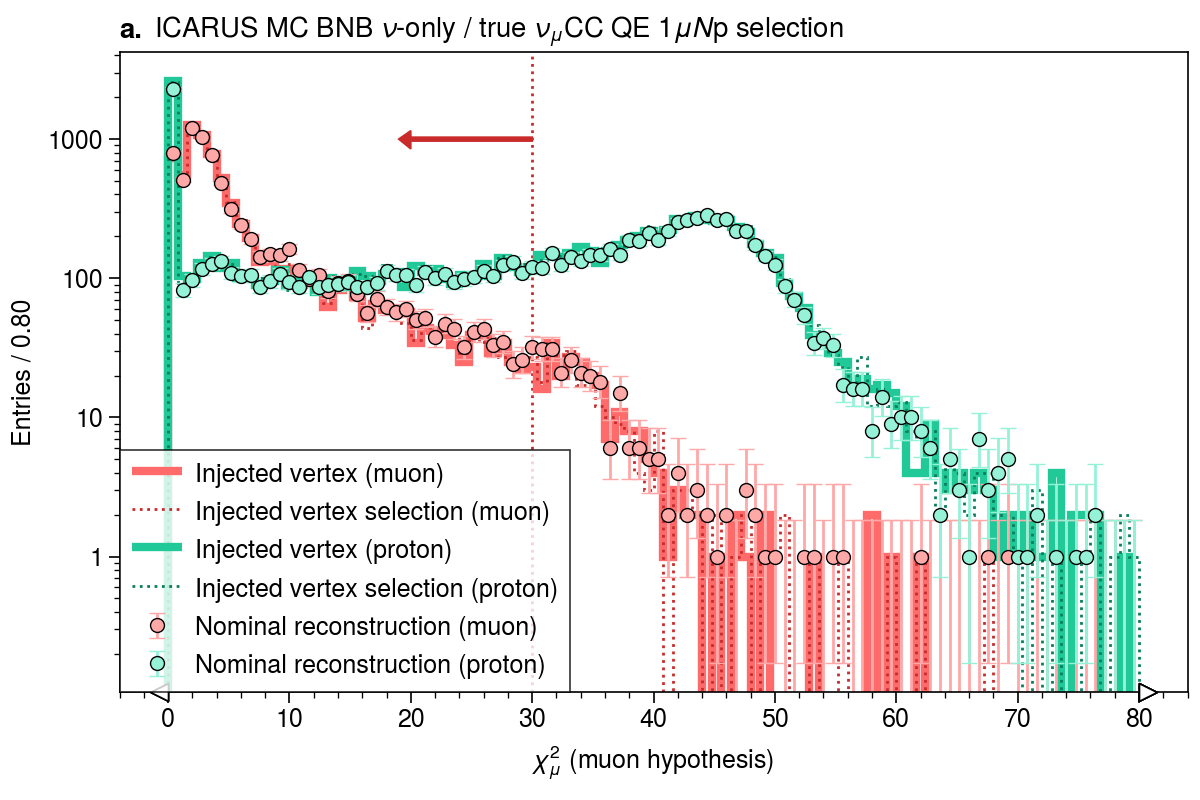

In [9]:
var='chi2_mu'
binning=hist.axis.Regular(100, 0, 80)

fig, ax = plot.subplots(
    width=6, height=4, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'$\chi^2_\mu$ (muon hypothesis)',
    abc='a.', 
    yscale='log'
)

(A,B,C), _ = CCNp_muonAna.get(['nominal', 'cheated_vtx', 'cheated_vtxSelection'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_vtx', var, binning)
C0, _ = CCNp_muonAna.get('cheated_vtxSelection', var, binning)

hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_vtx']} (muon)')
hep.histplot(C0, yerr=False, ax=ax[0], color='red9', lw=1, ls=':', label=f'{loader_formatted['cheated_vtxSelection']} (muon)')

(A,B,C), _ = CCNp_protonAna.get(['nominal', 'cheated_vtx', 'cheated_vtxSelection'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_vtx', var, binning)
C0, _ = CCNp_protonAna.get('cheated_vtxSelection', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=f'{loader_formatted['nominal']} (proton)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=f'{loader_formatted['cheated_vtx']} (proton)')
hep.histplot(C0, yerr=False, ax=ax[0], color='teal9', lw=1, ls=':', label=f'{loader_formatted['cheated_vtxSelection']} (proton)')

ax.axvline(30, lw=1, ls=':', color='red9', zorder=-99)
ax.arrow(30, 1000, -10, 0, color='red9', width=65, head_width=300, head_length=1)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ll', order='F', frameon=True)
fig.savefig('plots_CCNp_test/muonHyp_chi2_var.pdf', bbox_inches='tight')

## Vertex distance

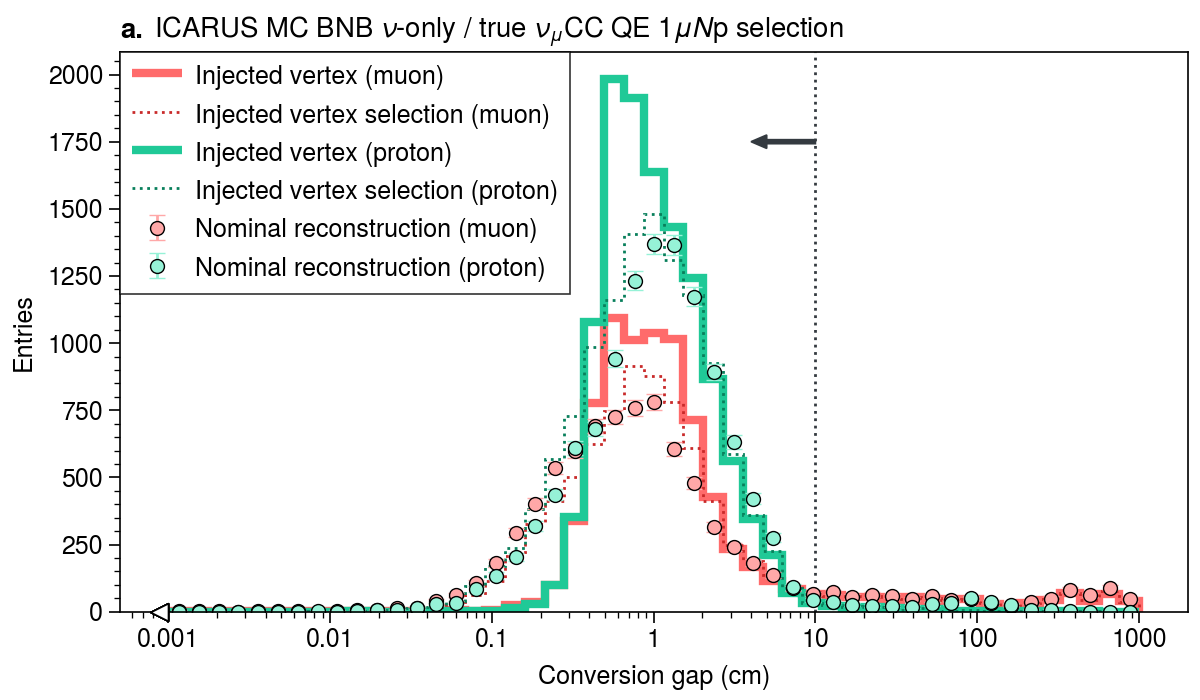

In [10]:
from hist import quick_construct

var='vtxDist'
binning=hist.axis.Variable(np.logspace(-3, 3))


fig, ax = plot.subplots(
    width=6, height=3.5, ncols=1, nrows=1, ylabel=f'Entries',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xlabel=r'Conversion gap (cm)',
    abc='a.', 
    # yscale='log',
    xscale='log'
)

(A,B,C), _ = CCNp_muonAna.get(['nominal', 'cheated_vtx', 'cheated_vtxSelection'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_vtx', var, binning)
C0, _ = CCNp_muonAna.get('cheated_vtxSelection', var, binning)

hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_vtx']} (muon)')
hep.histplot(C0, yerr=False, ax=ax[0], color='red9', lw=1, ls=':', label=f'{loader_formatted['cheated_vtxSelection']} (muon)')

(A,B,C), _ = CCNp_protonAna.get(['nominal', 'cheated_vtx', 'cheated_vtxSelection'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_vtx', var, binning)
C0, _ = CCNp_protonAna.get('cheated_vtxSelection', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=f'{loader_formatted['nominal']} (proton)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=f'{loader_formatted['cheated_vtx']} (proton)')
hep.histplot(C0, yerr=False, ax=ax[0], color='teal9', lw=1, ls=':', label=f'{loader_formatted['cheated_vtxSelection']} (proton)')

ax.axvline(10, lw=1, ls=':', color='gray8', zorder=-99)
ax.arrow(10, 1750, -5, 0, color='gray8', width=15, head_width=50, head_length=1)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ul', order='F', frameon=True)

fig.savefig('plots_CCNp_test/vtxDist_var.pdf', bbox_inches='tight')


## Track score

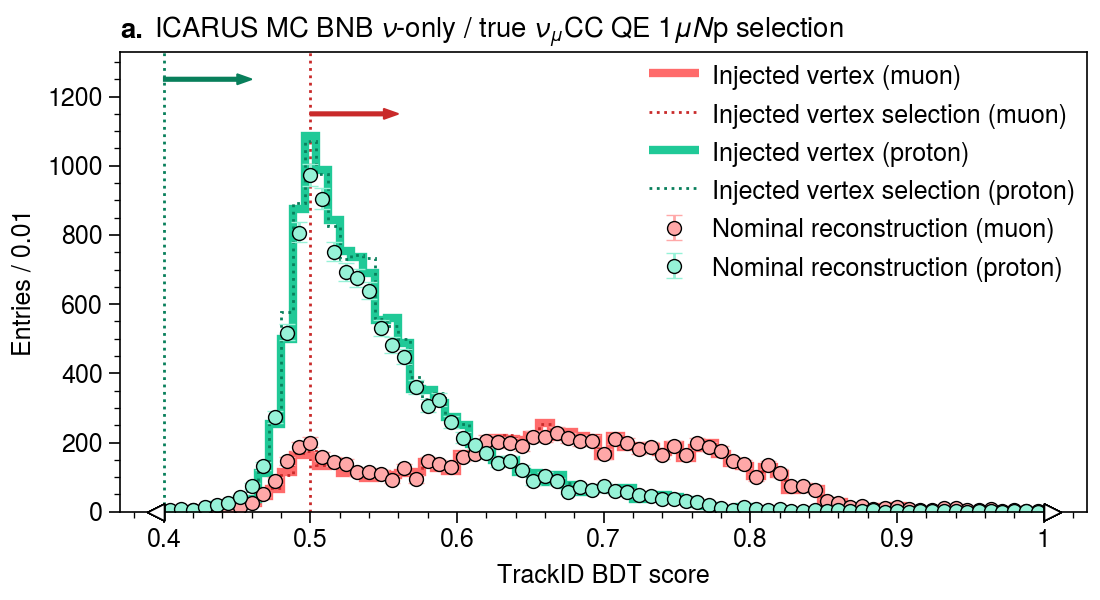

In [11]:

var='trackScore'
binning=hist.axis.Regular(75, 0.4, 1)

fig, ax = plot.subplots(
    width=5.5, height=3, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'TrackID BDT score',
    abc='a.', 
    # yscale='log'
)

(A,B,C), _ = CCNp_muonAna.get(['nominal', 'cheated_vtx', 'cheated_vtxSelection'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_vtx', var, binning)
C0, _ = CCNp_muonAna.get('cheated_vtxSelection', var, binning)

hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_vtx']} (muon)')
hep.histplot(C0, yerr=False, ax=ax[0], color='red9', lw=1, ls=':', label=f'{loader_formatted['cheated_vtxSelection']} (muon)')

(A,B,C), _ = CCNp_protonAna.get(['nominal', 'cheated_vtx', 'cheated_vtxSelection'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_vtx', var, binning)
C0, _ = CCNp_protonAna.get('cheated_vtxSelection', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=f'{loader_formatted['nominal']} (proton)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=f'{loader_formatted['cheated_vtx']} (proton)')
hep.histplot(C0, yerr=False, ax=ax[0], color='teal9', lw=1, ls=':', label=f'{loader_formatted['cheated_vtxSelection']} (proton)')


ax.axvline(0.5, lw=1, ls=':', color='red9', zorder=-99)
ax.arrow(0.5, 1150, 0.05, 0, color='red9', width=10, head_width=30, head_length=0.01)

ax.axvline(0.4, lw=1, ls=':', color='teal9', zorder=-99)
ax.arrow(0.4, 1250, 0.05, 0, color='teal9', width=10, head_width=30, head_length=0.01)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ur', order='F')

## Muon track length

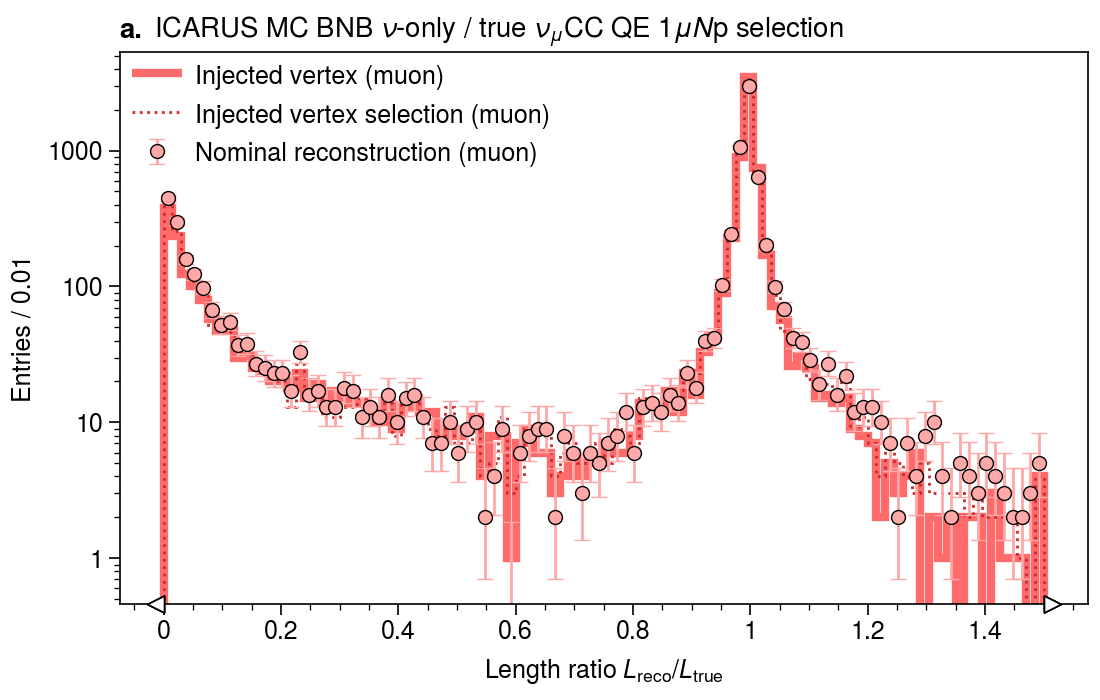

In [12]:
var='length_ratio'
binning=hist.axis.Regular(100, 0, 1.5)

fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'Length ratio $L_\mathrm{reco}/L_\mathrm{true}$',
    abc='a.', 
    yscale='log'
)

(A,B,C), _ = CCNp_muonAna.get(['nominal', 'cheated_vtx', 'cheated_vtxSelection'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_vtx', var, binning)
C0, _ = CCNp_muonAna.get('cheated_vtxSelection', var, binning)

hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_vtx']} (muon)')
hep.histplot(C0, yerr=False, ax=ax[0], color='red9', lw=1, ls=':', label=f'{loader_formatted['cheated_vtxSelection']} (muon)')

# ax.axvline(30, lw=1, ls=':', color='red9', zorder=-99)
# ax.arrow(30, 1000, -10, 0, color='red9', width=65, head_width=300, head_length=1)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ul', order='F')

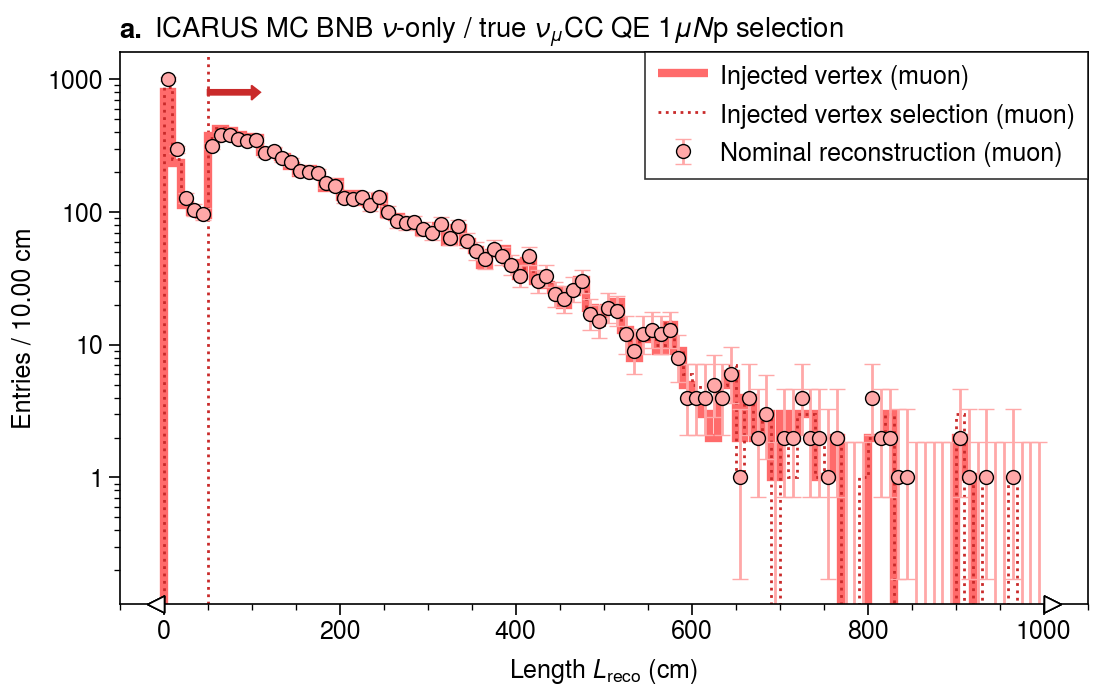

In [13]:
var='length'
binning=hist.axis.Regular(100, 0, 1000)

fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f} cm',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'Length $L_\mathrm{reco}$ (cm)',
    abc='a.', 
    yscale='log'
)

(A,B,C), _ = CCNp_muonAna.get(['nominal', 'cheated_vtx', 'cheated_vtxSelection'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_vtx', var, binning)
C0, _ = CCNp_muonAna.get('cheated_vtxSelection', var, binning)

hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_vtx']} (muon)')
hep.histplot(C0, yerr=False, ax=ax[0], color='red9', lw=1, ls=':', label=f'{loader_formatted['cheated_vtxSelection']} (muon)')

ax.axvline(50, lw=1, ls=':', color='red9', zorder=-99)
ax.arrow(50, 800, 50, 0, color='red9', width=70, head_width=200, head_length=10)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ur', order='F', frameon=True)

fig.savefig('plots_CCNp_test/muonLength_var.pdf', bbox_inches='tight')

## Proton deposited energy

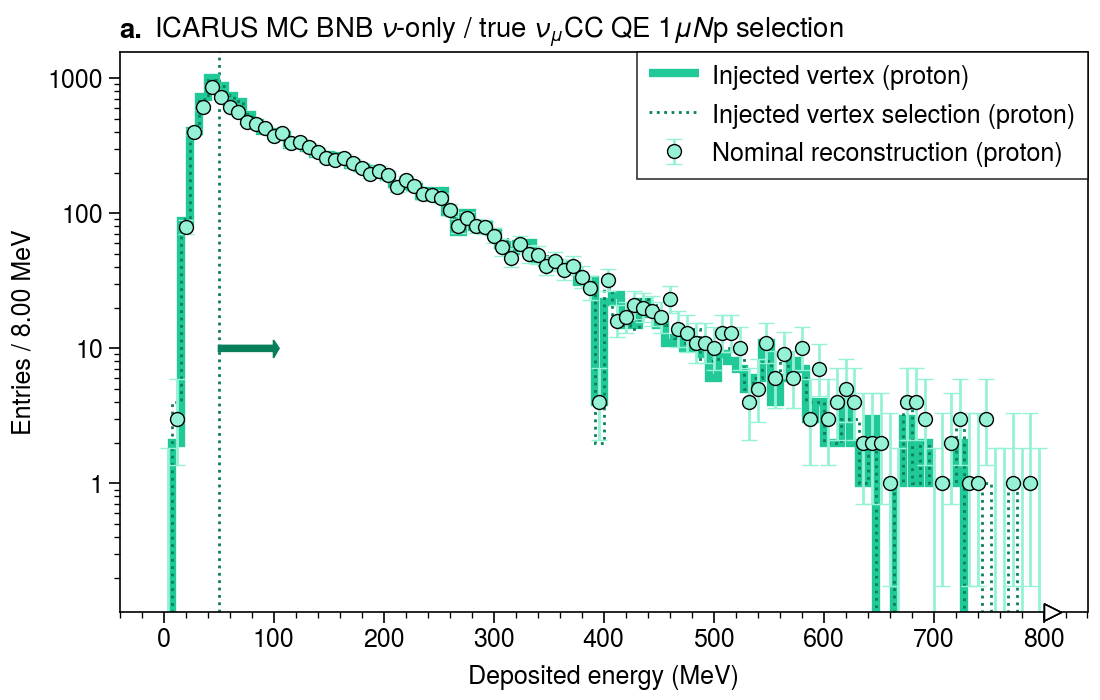

In [14]:
var='depEnergy'
binning=hist.axis.Regular(100, 0, 800)
# binning=hist.axis.Variable(np.logspace(1, 3, 100))

fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f} MeV',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'Deposited energy (MeV)',
    abc='a.', 
    yscale='log',
    # xscale='log'
)

(A,B,C), _ = CCNp_protonAna.get(['nominal', 'cheated_vtx', 'cheated_vtxSelection'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_vtx', var, binning)
C0, _ = CCNp_protonAna.get('cheated_vtxSelection', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=f'{loader_formatted['nominal']} (proton)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=f'{loader_formatted['cheated_vtx']} (proton)')
hep.histplot(C0, yerr=False, ax=ax[0], color='teal9', lw=1, ls=':', label=f'{loader_formatted['cheated_vtxSelection']} (proton)')

ax.axvline(50, lw=1, ls=':', color='teal9', zorder=-99)
ax.arrow(50, 10, 50, 0, color='teal9', width=1, head_width=3, head_length=5)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ur', order='F', frameon=True)

fig.savefig('plots_CCNp_test/protonEDep_var.pdf', bbox_inches='tight')

# 3D matching deficit, from the cuts

The 3D matching decrease by a factor of 6.5%, why is that? 
Looking at the variables of the selection
1. µID loose by 5%
2. pID improves by 7% (-1% wrt µID, so still interesting)
3. gamma better...(?)





## Hit completeness/purity

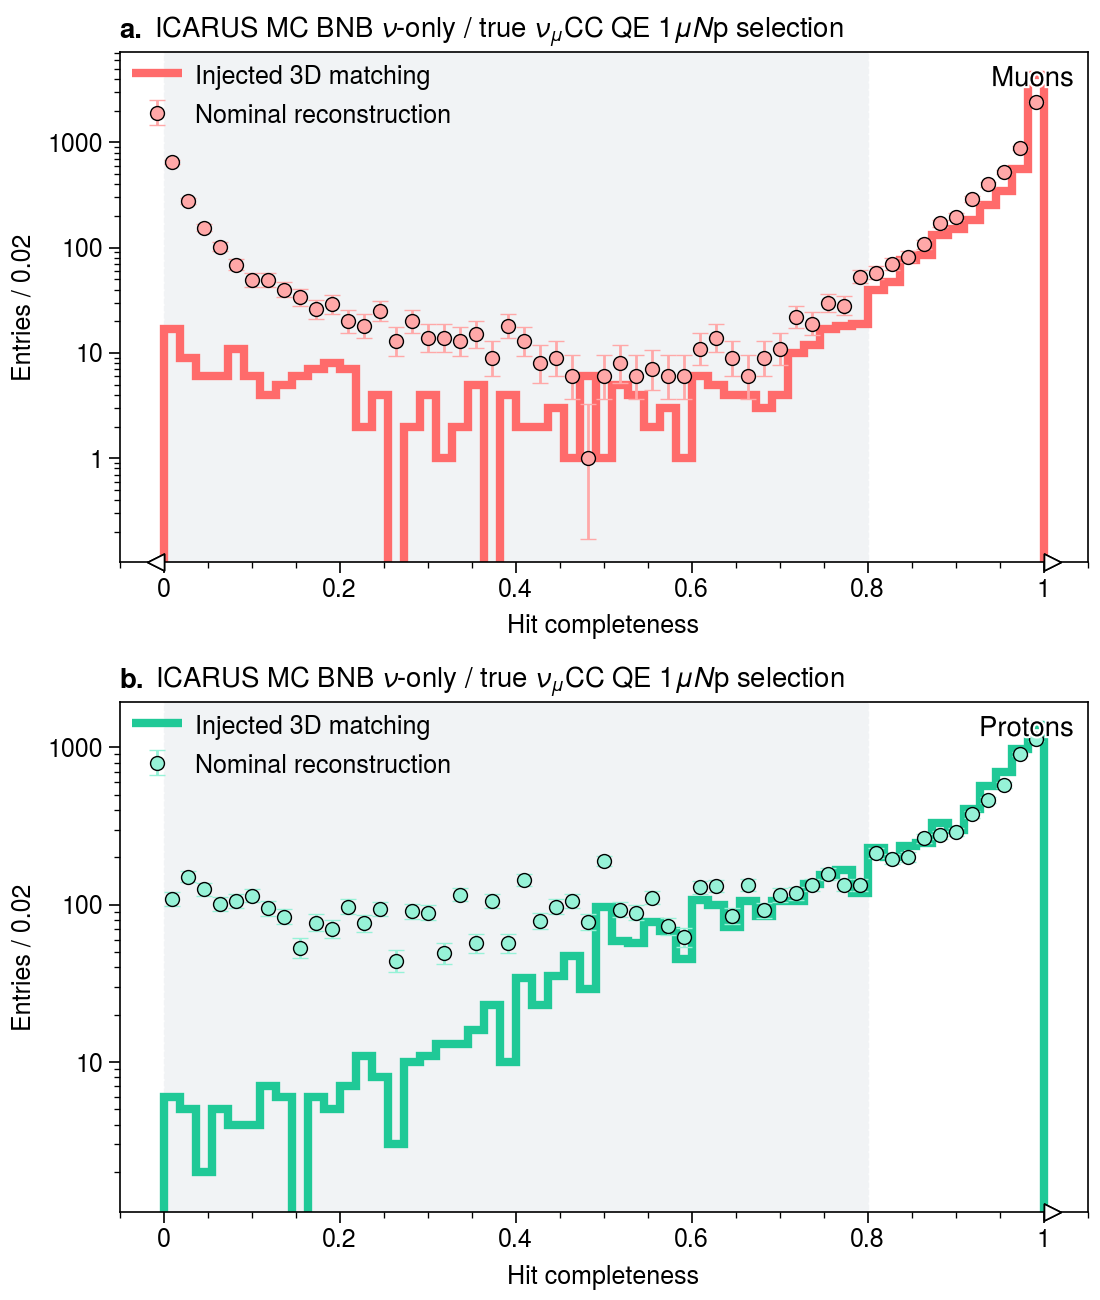

In [15]:

binning=hist.axis.Regular(55, 0, 1)
fig, ax = plot.subplots(
    width=5.5, height=6.5, ncols=1, nrows=2, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xlabel='Hit completeness',
    abc='a.', 
    yscale='log'
)
var='completeness'

(A,B), _ = CCNp_muonAna.get(['nominal', 'cheated_3d'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_3d', var, binning)

hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=loader_formatted['nominal'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=loader_formatted['cheated_3d'])
ax[0].format(urtitle='Muons')

(A,B), _ = CCNp_protonAna.get(['nominal', 'cheated_3d'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_3d', var, binning)
hep.histplot(A0, ax=ax[1], color='teal2', histtype='errorbar', label=loader_formatted['nominal'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[1], color='teal5', lw=3, label=loader_formatted['cheated_3d'])
ax[1].format(urtitle='Protons')

[axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
[axi.legend(ncols=1) for axi in ax]


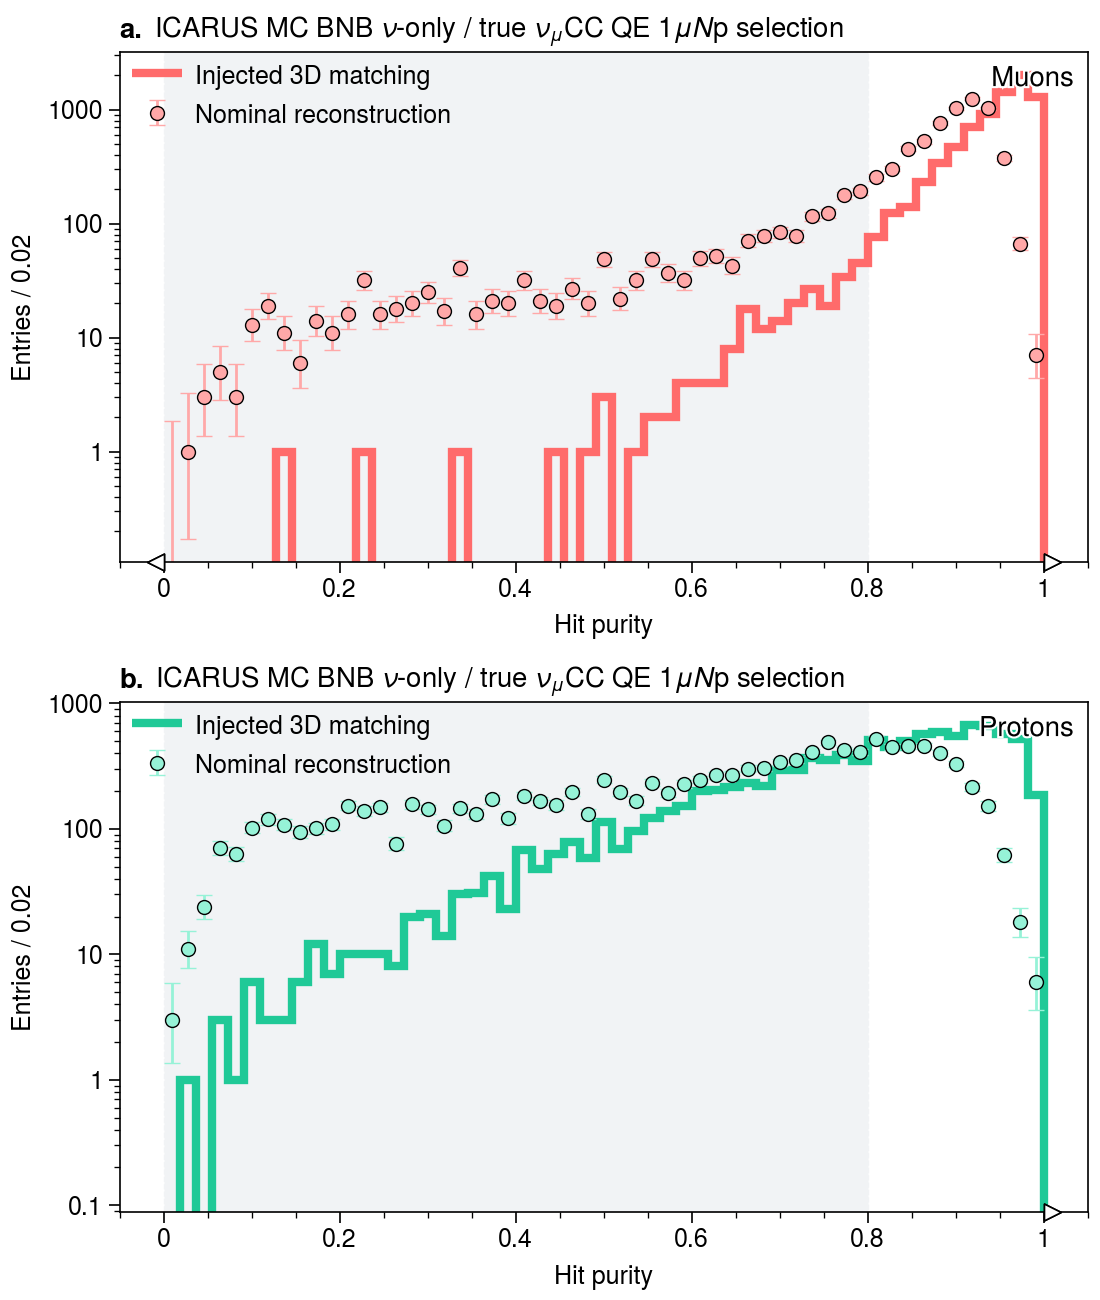

In [16]:

binning=hist.axis.Regular(55, 0, 1)
fig, ax = plot.subplots(
    width=5.5, height=6.5, ncols=1, nrows=2, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xlabel='Hit purity',
    abc='a.', 
    yscale='log'
)

var='purity'

(A,B), _ = CCNp_muonAna.get(['nominal', 'cheated_3d'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_3d', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=loader_formatted['nominal'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=loader_formatted['cheated_3d'])
ax[0].format(urtitle='Muons')

(A,B), _ = CCNp_protonAna.get(['nominal', 'cheated_3d'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_3d', var, binning)
hep.histplot(A0, ax=ax[1], color='teal2', histtype='errorbar', label=loader_formatted['nominal'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[1], color='teal5', lw=3, label=loader_formatted['cheated_3d'])
ax[1].format(urtitle='Protons')


[axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
[axi.legend(ncols=1) for axi in ax]

## $\chi^2$ selection variables
The muons selction requires 
- $\chi^2_\mu < 30$
- $\chi^2_p > 60$

The protons selection 
- $\chi^2_p < 100$

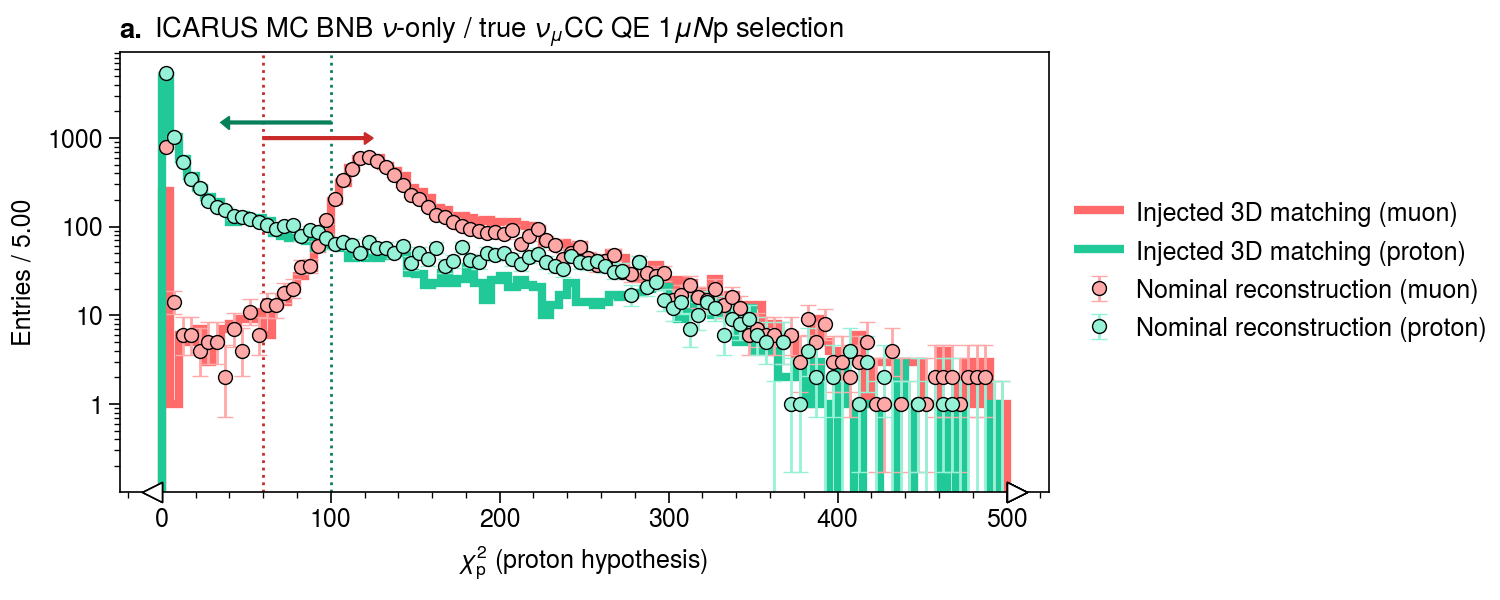

In [17]:

var='chi2_proton'
binning=hist.axis.Regular(100, 0, 500)

fig, ax = plot.subplots(
    width=7.5, height=3, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'$\chi^2_\mathrm{p}$ (proton hypothesis)',
    abc='a.', 
    yscale='log'
)

(A,B), _ = CCNp_muonAna.get(['nominal', 'cheated_3d'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_3d', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_3d']} (muon)')

(A,B), _ = CCNp_protonAna.get(['nominal', 'cheated_3d'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_3d', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=f'{loader_formatted['nominal']} (proton)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=f'{loader_formatted['cheated_3d']} (proton)')

ax.axvline(60, lw=1, ls=':', color='red9', zorder=-99)
ax.arrow(60, 1000, 60, 0, color='red9', width=65, head_width=300, head_length=5)
ax.axvline(100, lw=1, ls=':', color='teal9', zorder=-99)
ax.arrow(100, 1500, -60, 0, color='teal9', width=100, head_width=500, head_length=5)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
fig.legend(ncols=1, loc='r', order='F')

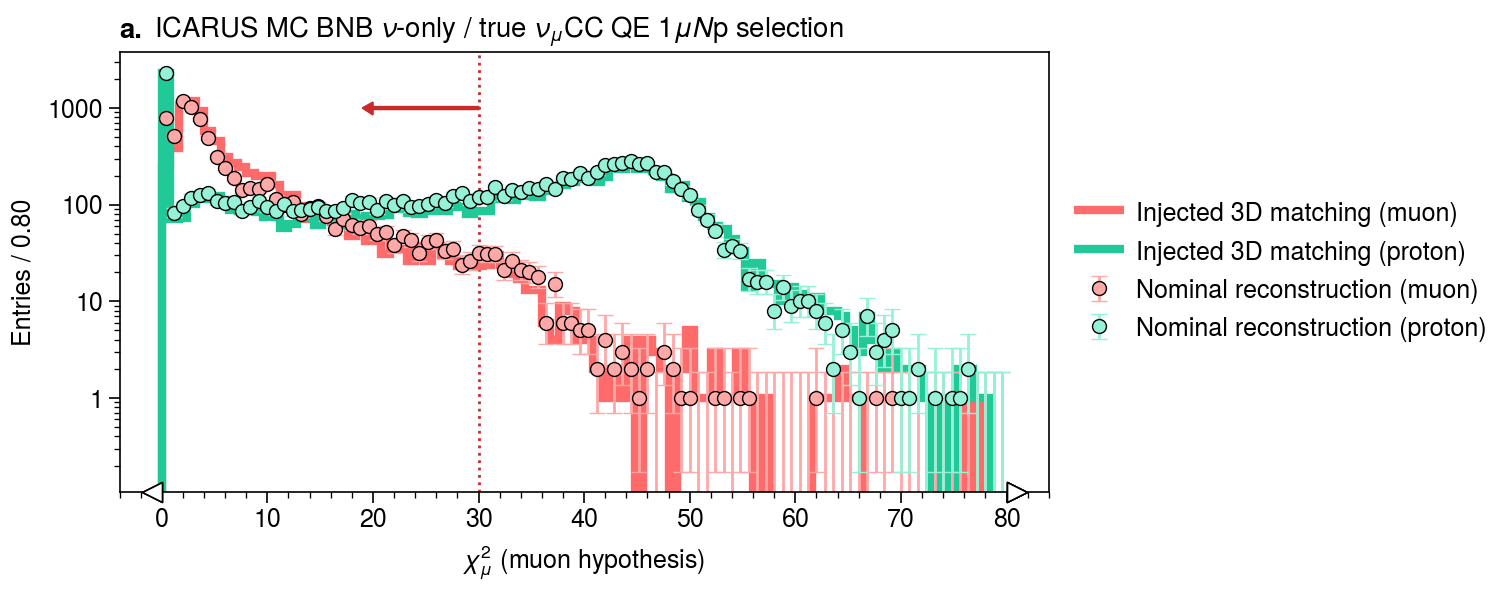

In [18]:
var='chi2_mu'
binning=hist.axis.Regular(100, 0, 80)

fig, ax = plot.subplots(
    width=7.5, height=3, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'$\chi^2_\mu$ (muon hypothesis)',
    abc='a.', 
    yscale='log'
)

(A,B), _ = CCNp_muonAna.get(['nominal', 'cheated_3d'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_3d', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_3d']} (muon)')

(A,B), _ = CCNp_protonAna.get(['nominal', 'cheated_3d'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_3d', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=f'{loader_formatted['nominal']} (proton)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=f'{loader_formatted['cheated_3d']} (proton)')
# ax[0].format(urtitle='Protons')

ax.axvline(30, lw=1, ls=':', color='red9', zorder=-99)
ax.arrow(30, 1000, -10, 0, color='red9', width=65, head_width=300, head_length=1)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
fig.legend(ncols=1, loc='r', order='F')

## Vertex distance

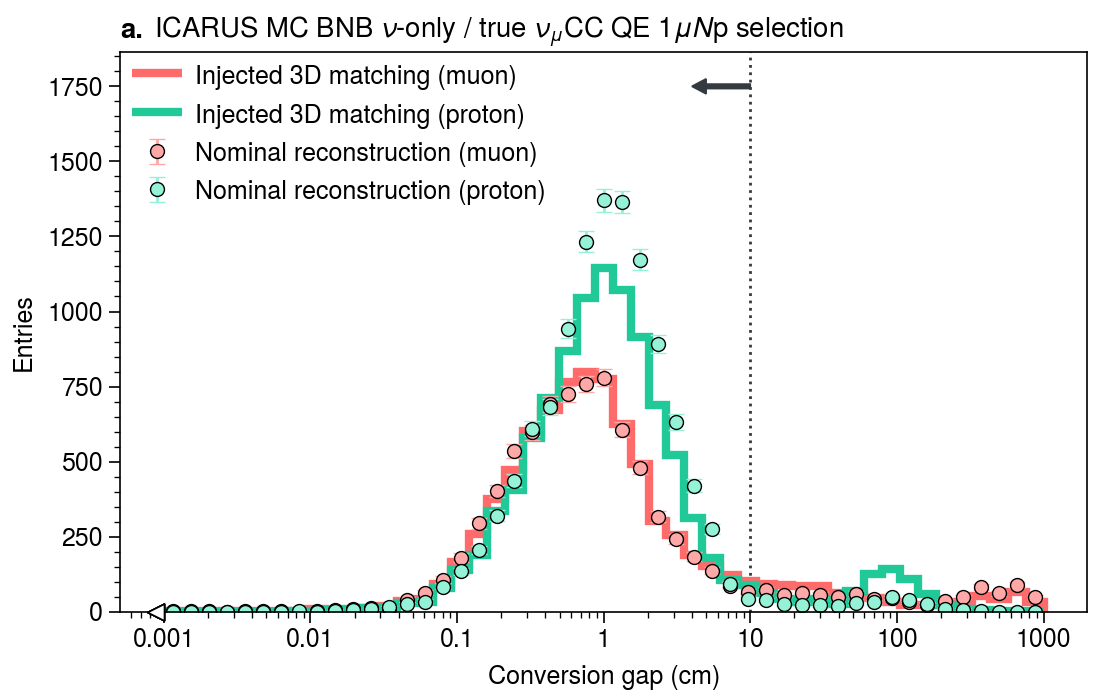

In [19]:
from hist import quick_construct

var='vtxDist'
binning=hist.axis.Variable(np.logspace(-3, 3))


fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Entries',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xlabel=r'Conversion gap (cm)',
    abc='a.', 
    # yscale='log',
    xscale='log'
)

(A,B), _ = CCNp_muonAna.get(['nominal', 'cheated_3d'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_3d', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_3d']} (muon)')
# ax[0].format(urtitle='Muons')

(A,B), _ = CCNp_protonAna.get(['nominal', 'cheated_3d'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_3d', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=f'{loader_formatted['nominal']} (proton)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=f'{loader_formatted['cheated_3d']} (proton)')
# ax[0].format(urtitle='Protons')

ax.axvline(10, lw=1, ls=':', color='gray8', zorder=-99)
ax.arrow(10, 1750, -5, 0, color='gray8', width=15, head_width=50, head_length=1)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ul', order='F')




## Track score

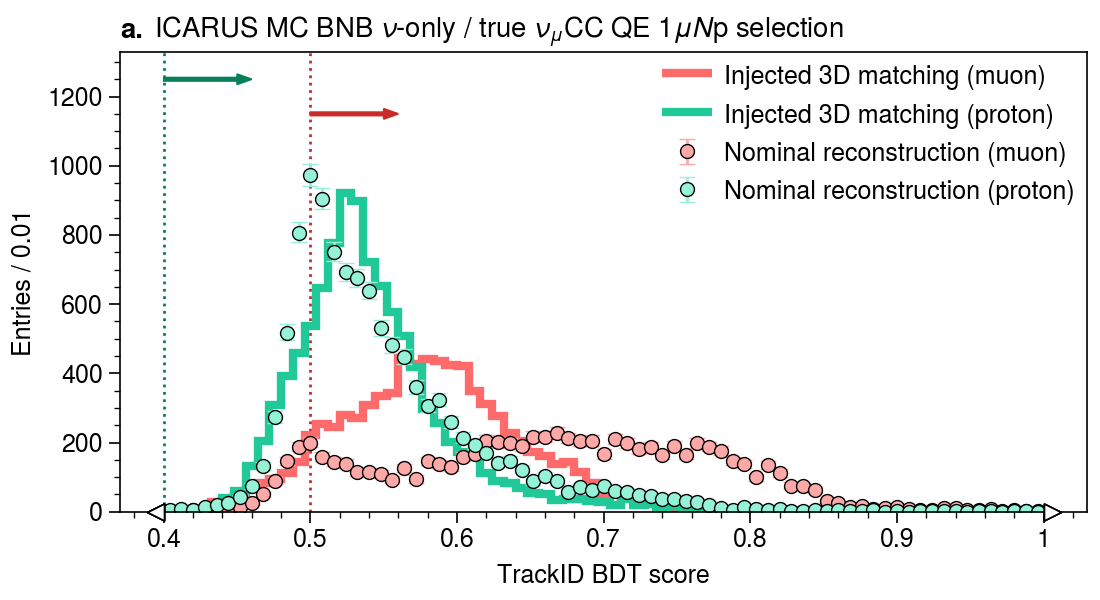

In [20]:

var='trackScore'
binning=hist.axis.Regular(75, 0.4, 1)

fig, ax = plot.subplots(
    width=5.5, height=3, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'TrackID BDT score',
    abc='a.', 
    # yscale='log'
)

(A,B), _ = CCNp_muonAna.get(['nominal', 'cheated_3d'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_3d', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_3d']} (muon)')


(A,B), _ = CCNp_protonAna.get(['nominal', 'cheated_3d'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_3d', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=f'{loader_formatted['nominal']} (proton)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=f'{loader_formatted['cheated_3d']} (proton)')


ax.axvline(0.5, lw=1, ls=':', color='red9', zorder=-99)
ax.arrow(0.5, 1150, 0.05, 0, color='red9', width=10, head_width=30, head_length=0.01)

ax.axvline(0.4, lw=1, ls=':', color='teal9', zorder=-99)
ax.arrow(0.4, 1250, 0.05, 0, color='teal9', width=10, head_width=30, head_length=0.01)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ur', order='F')

## Muon track length

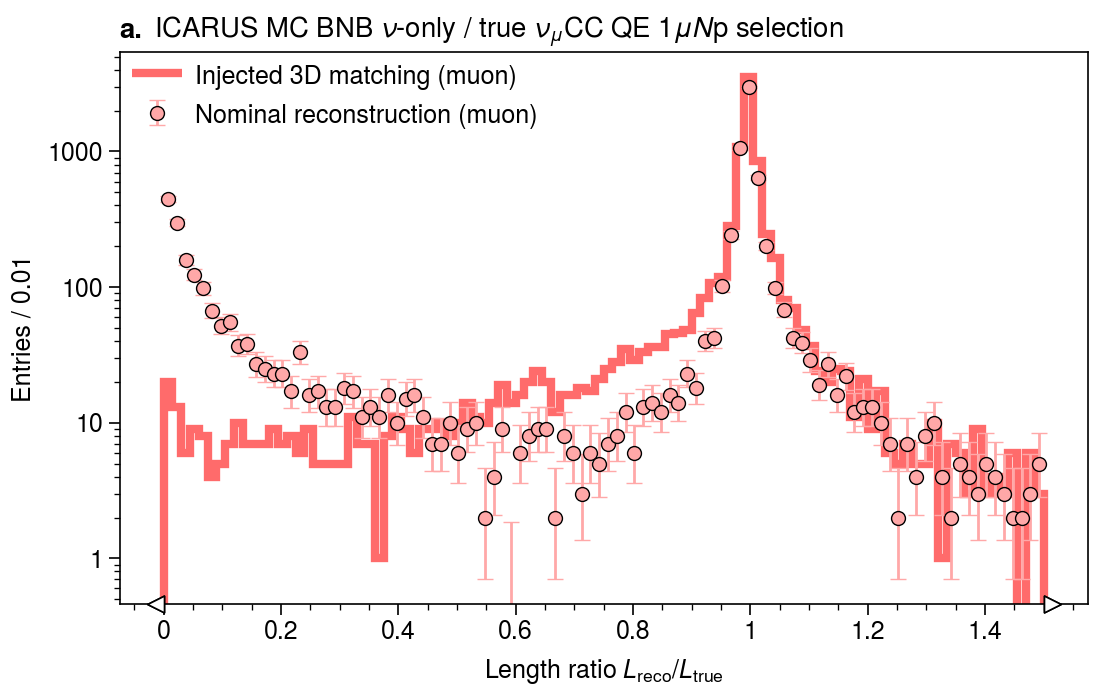

In [21]:
var='length_ratio'
binning=hist.axis.Regular(100, 0, 1.5)

fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'Length ratio $L_\mathrm{reco}/L_\mathrm{true}$',
    abc='a.', 
    yscale='log'
)

(A,B), _ = CCNp_muonAna.get(['nominal', 'cheated_3d'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_3d', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_3d']} (muon)')
# ax[0].format(urtitle='Muons')

# ax.axvline(30, lw=1, ls=':', color='red9', zorder=-99)
# ax.arrow(30, 1000, -10, 0, color='red9', width=65, head_width=300, head_length=1)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ul', order='F')

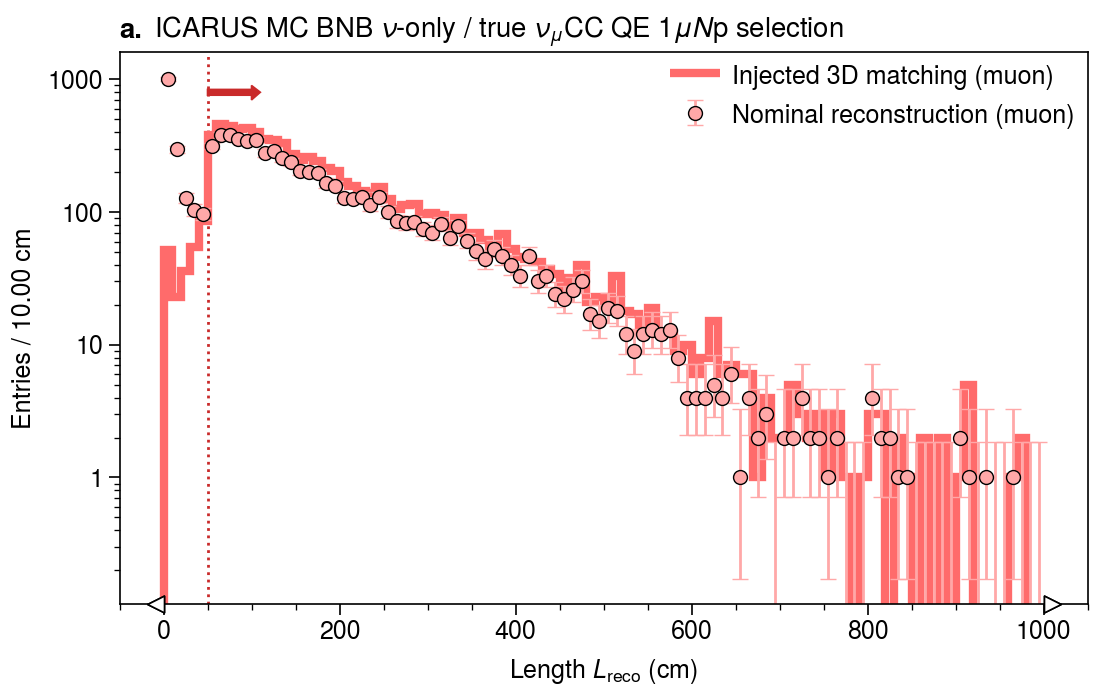

In [22]:
var='length'
binning=hist.axis.Regular(100, 0, 1000)

fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f} cm',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'Length $L_\mathrm{reco}$ (cm)',
    abc='a.', 
    yscale='log'
)

A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_3d', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_3d']} (muon)')

ax.axvline(50, lw=1, ls=':', color='red9', zorder=-99)
ax.arrow(50, 800, 50, 0, color='red9', width=80, head_width=200, head_length=10)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ur', order='F')

## Proton deposited energy

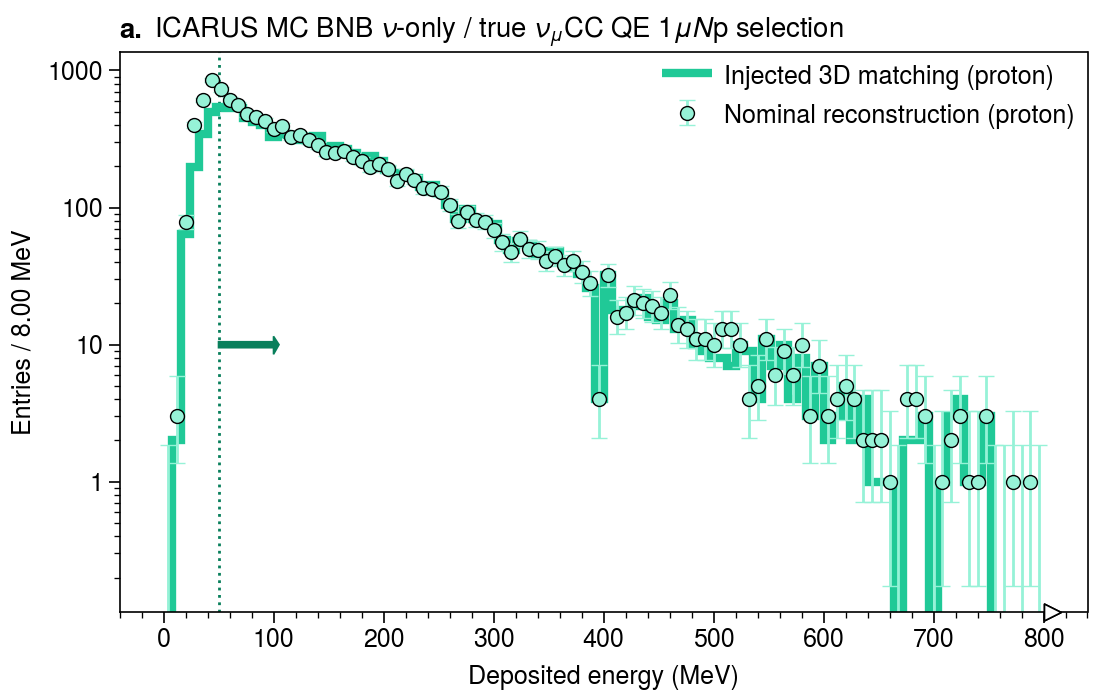

In [23]:
var='depEnergy'
binning=hist.axis.Regular(100, 0, 800)
# binning=hist.axis.Variable(np.logspace(1, 3, 100))

fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f} MeV',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'Deposited energy (MeV)',
    abc='a.', 
    yscale='log',
    # xscale='log'
)

A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_3d', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=f'{loader_formatted['nominal']} (proton)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=f'{loader_formatted['cheated_3d']} (proton)')

ax.axvline(50, lw=1, ls=':', color='teal9', zorder=-99)
ax.arrow(50, 10, 50, 0, color='teal9', width=1, head_width=3, head_length=5)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ur', order='F')

# $\nu$-hierarchy deficit, from the cuts

The $\nu$-hierarchy decrease by a factor of 19.4%, why is that? 
Looking at the variables of the selection
1. µID gain 3%
2. pID loose by 25% (-1% wrt µID, so still interesting)
3. gamma better...(?)

Here I am inspecting the ``common'' events



## Hit completeness/purity

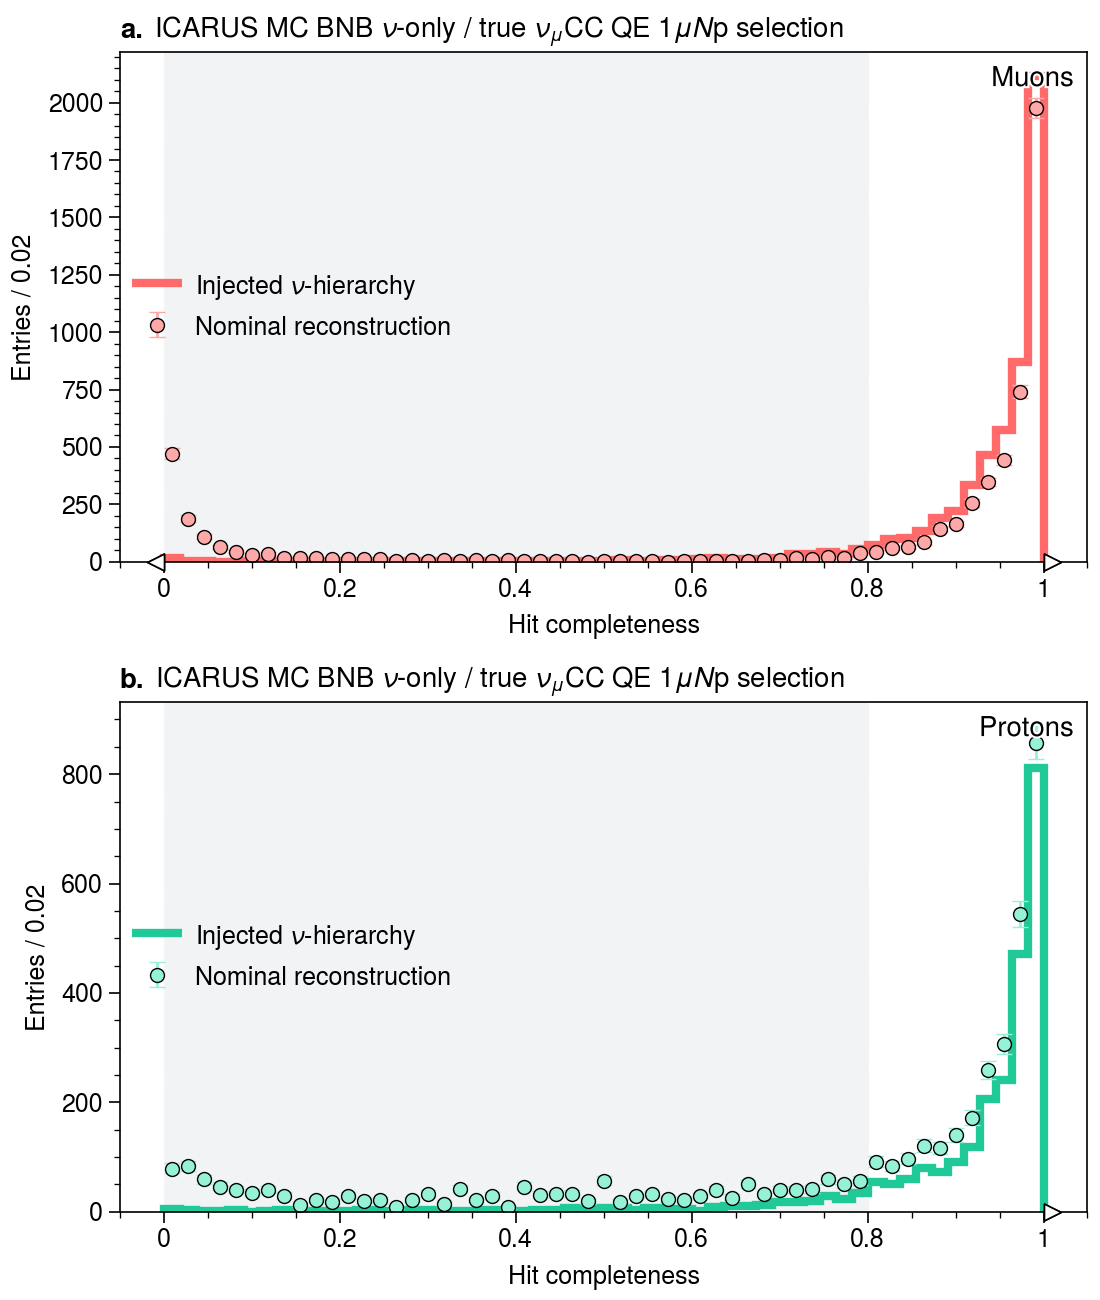

In [24]:

binning=hist.axis.Regular(55, 0, 1)
fig, ax = plot.subplots(
    width=5.5, height=6.5, ncols=1, nrows=2, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xlabel='Hit completeness',
    abc='a.', 
    # yscale='log'
)
var='completeness'

(A,B), _ = CCNp_muonAna.get(['nominal', 'cheated_nuH'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_nuH', var, binning)

hep.histplot(A, ax=ax[0], color='red3', histtype='errorbar', label=loader_formatted['nominal'], mec='k', markeredgewidth=0.5)
hep.histplot(B, yerr=False, ax=ax[0], color='red5', lw=3, label=loader_formatted['cheated_nuH'])
ax[0].format(urtitle='Muons')

(A,B), _ = CCNp_protonAna.get(['nominal', 'cheated_nuH'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_nuH', var, binning)
hep.histplot(A, ax=ax[1], color='teal2', histtype='errorbar', label=loader_formatted['nominal'], mec='k', markeredgewidth=0.5)
hep.histplot(B, yerr=False, ax=ax[1], color='teal5', lw=3, label=loader_formatted['cheated_nuH'])
ax[1].format(urtitle='Protons')

[axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
[axi.legend(ncols=1) for axi in ax]


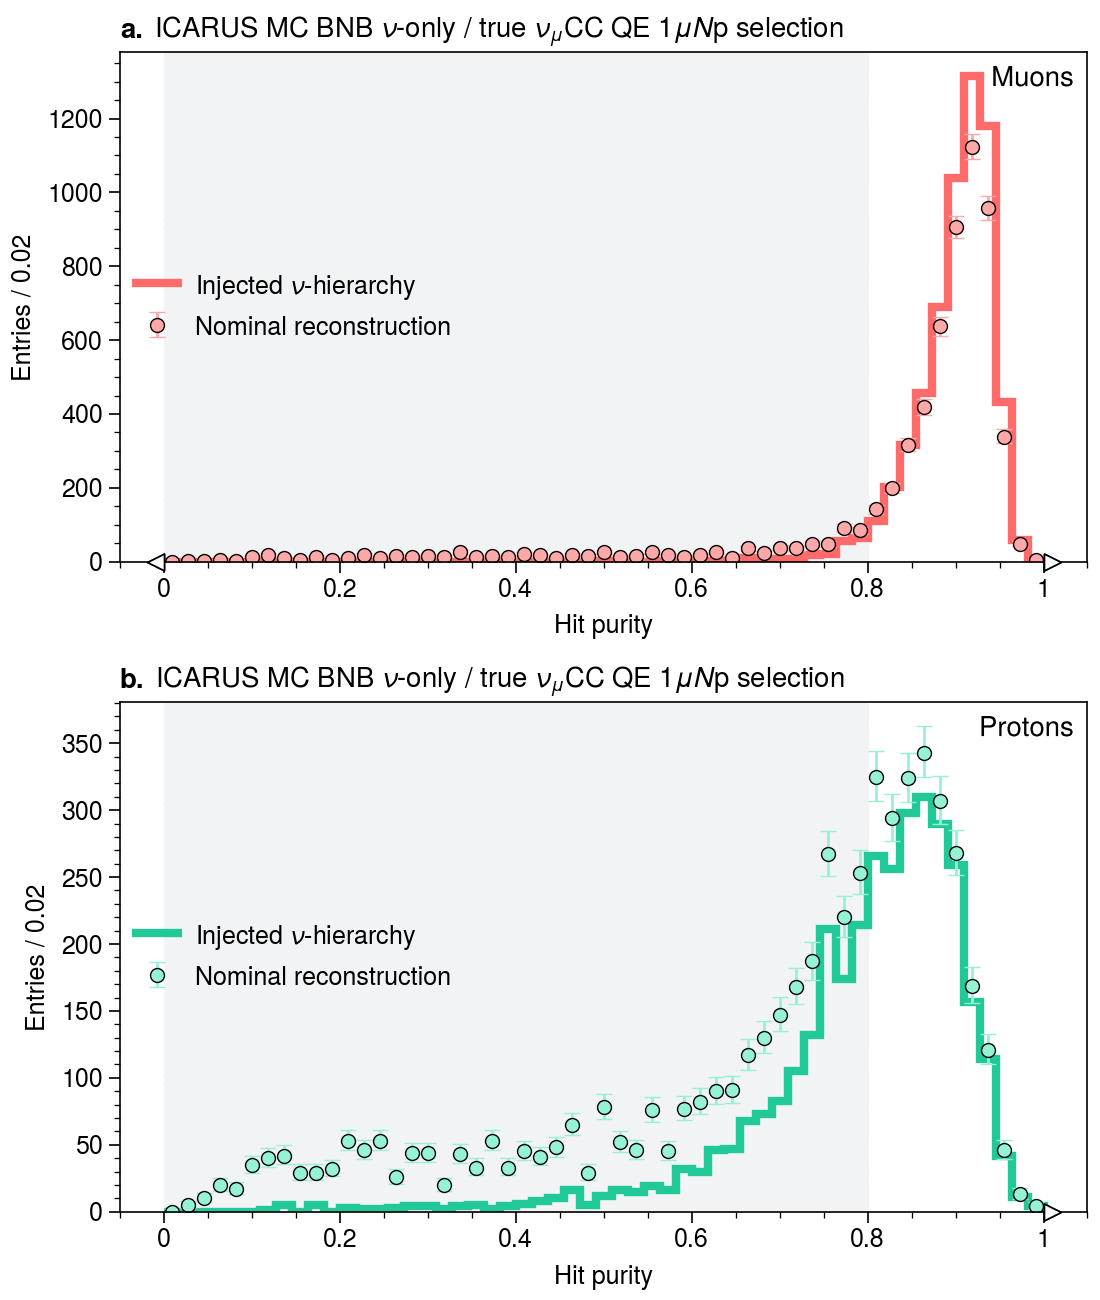

In [25]:

binning=hist.axis.Regular(55, 0, 1)
fig, ax = plot.subplots(
    width=5.5, height=6.5, ncols=1, nrows=2, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xlabel='Hit purity',
    abc='a.', 
    # yscale='log'
)

var='purity'

(A,B), _ = CCNp_muonAna.get(['nominal', 'cheated_nuH'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_nuH', var, binning)
hep.histplot(A, ax=ax[0], color='red3', histtype='errorbar', label=loader_formatted['nominal'], mec='k', markeredgewidth=0.5)
hep.histplot(B, yerr=False, ax=ax[0], color='red5', lw=3, label=loader_formatted['cheated_nuH'])
ax[0].format(urtitle='Muons')

(A,B), _ = CCNp_protonAna.get(['nominal', 'cheated_nuH'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_nuH', var, binning)
hep.histplot(A, ax=ax[1], color='teal2', histtype='errorbar', label=loader_formatted['nominal'], mec='k', markeredgewidth=0.5)
hep.histplot(B, yerr=False, ax=ax[1], color='teal5', lw=3, label=loader_formatted['cheated_nuH'])
ax[1].format(urtitle='Protons')


[axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
[axi.legend(ncols=1) for axi in ax]

## $\chi^2$ selection variables
The muons selction requires 
- $\chi^2_\mu < 30$
- $\chi^2_p > 60$

The protons selection 
- $\chi^2_p < 100$

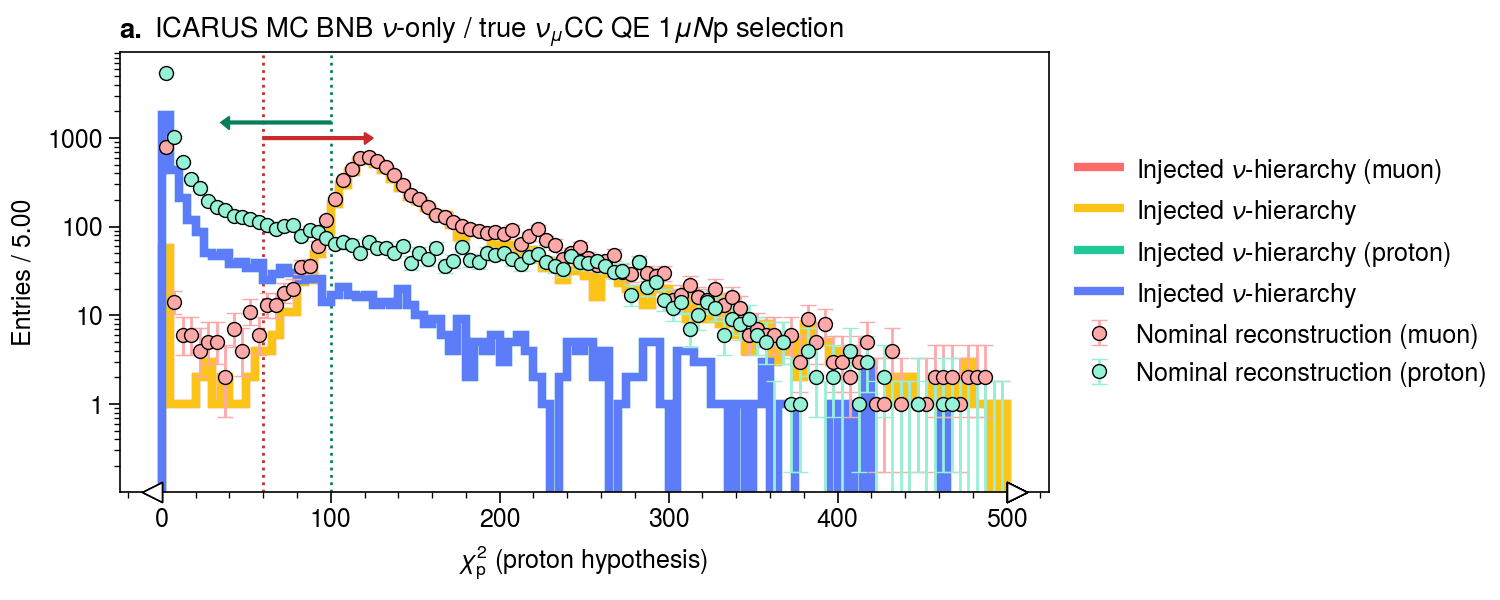

In [26]:

var='chi2_proton'
binning=hist.axis.Regular(100, 0, 500)

fig, ax = plot.subplots(
    width=7.5, height=3, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'$\chi^2_\mathrm{p}$ (proton hypothesis)',
    abc='a.', 
    yscale='log'
)

(A,B), _ = CCNp_muonAna.get(['nominal', 'cheated_nuH'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_nuH', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_nuH']} (muon)')

A0, _ = CCNp_muonAna.get('nominal', var, binning, conditions={'pandoraPrimary': 1})
B0, _ = CCNp_muonAna.get('cheated_nuH', var, binning, conditions={'pandoraPrimary': 1})
# hep.histplot(A0, ax=ax[0], color='yellow3', histtype='errorbar', label=loader_formatted['nominal'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='yellow5', lw=3, label=loader_formatted['cheated_nuH'])

(A,B), _ = CCNp_protonAna.get(['nominal', 'cheated_nuH'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_nuH', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=f'{loader_formatted['nominal']} (proton)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=f'{loader_formatted['cheated_nuH']} (proton)')

A0, _ = CCNp_protonAna.get('nominal', var, binning, conditions={'pandoraPrimary': 1})
B0, _ = CCNp_protonAna.get('cheated_nuH', var, binning, conditions={'pandoraPrimary': 1})
# hep.histplot(A0, ax=ax[0], color='indigo3', histtype='errorbar', label=loader_formatted['nominal'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='indigo5', lw=3, label=loader_formatted['cheated_nuH'])

ax.axvline(60, lw=1, ls=':', color='red9', zorder=-99)
ax.arrow(60, 1000, 60, 0, color='red9', width=65, head_width=300, head_length=5)
ax.axvline(100, lw=1, ls=':', color='teal9', zorder=-99)
ax.arrow(100, 1500, -60, 0, color='teal9', width=100, head_width=500, head_length=5)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
fig.legend(ncols=1, loc='r', order='F')

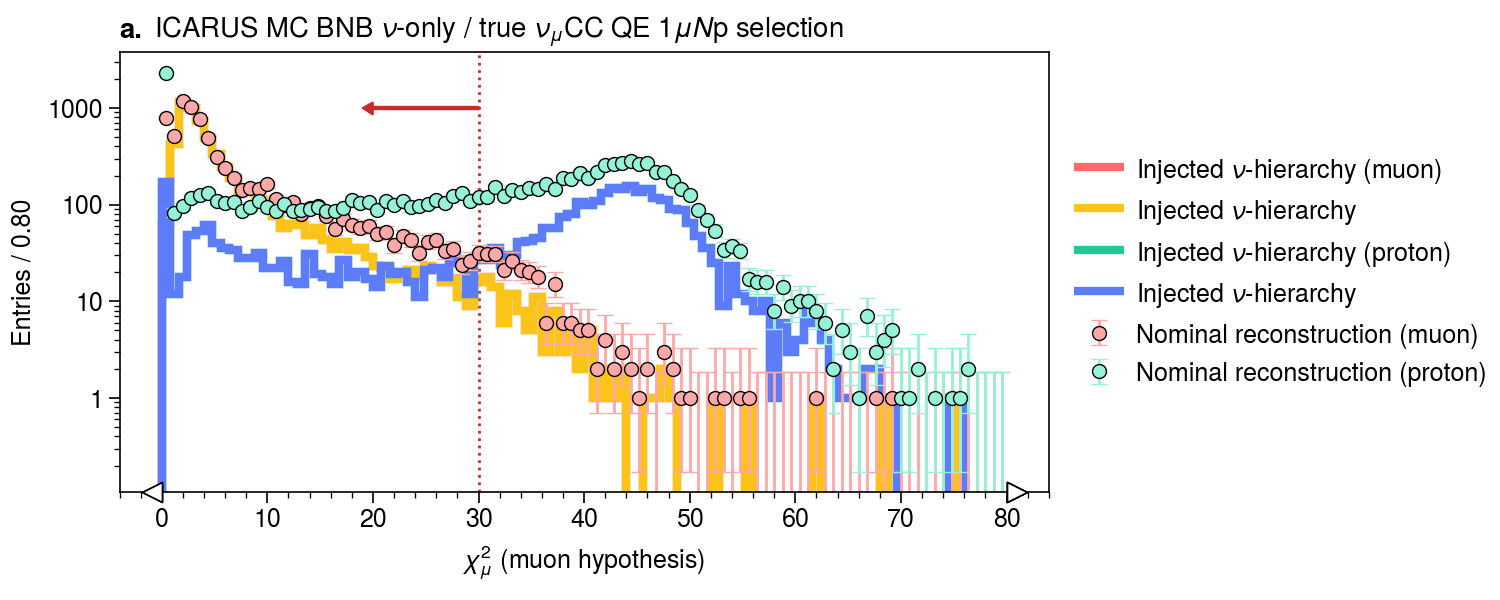

In [27]:
var='chi2_mu'
binning=hist.axis.Regular(100, 0, 80)

fig, ax = plot.subplots(
    width=7.5, height=3, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'$\chi^2_\mu$ (muon hypothesis)',
    abc='a.', 
    yscale='log'
)

(A,B), _ = CCNp_muonAna.get(['nominal', 'cheated_nuH'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_nuH', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_nuH']} (muon)')

A0, _ = CCNp_muonAna.get('nominal', var, binning, conditions={'pandoraPrimary': 1})
B0, _ = CCNp_muonAna.get('cheated_nuH', var, binning, conditions={'pandoraPrimary': 1})
# hep.histplot(A0, ax=ax[0], color='yellow3', histtype='errorbar', label=loader_formatted['nominal'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='yellow5', lw=3, label=loader_formatted['cheated_nuH'])

(A,B), _ = CCNp_protonAna.get(['nominal', 'cheated_nuH'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_nuH', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=f'{loader_formatted['nominal']} (proton)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=f'{loader_formatted['cheated_nuH']} (proton)')
# ax[0].format(urtitle='Protons')

A0, _ = CCNp_protonAna.get('nominal', var, binning, conditions={'pandoraPrimary': 1})
B0, _ = CCNp_protonAna.get('cheated_nuH', var, binning, conditions={'pandoraPrimary': 1})
# hep.histplot(A0, ax=ax[0], color='indigo3', histtype='errorbar', label=loader_formatted['nominal'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='indigo5', lw=3, label=loader_formatted['cheated_nuH'])

ax.axvline(30, lw=1, ls=':', color='red9', zorder=-99)
ax.arrow(30, 1000, -10, 0, color='red9', width=65, head_width=300, head_length=1)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
fig.legend(ncols=1, loc='r', order='F')

## Vertex distance

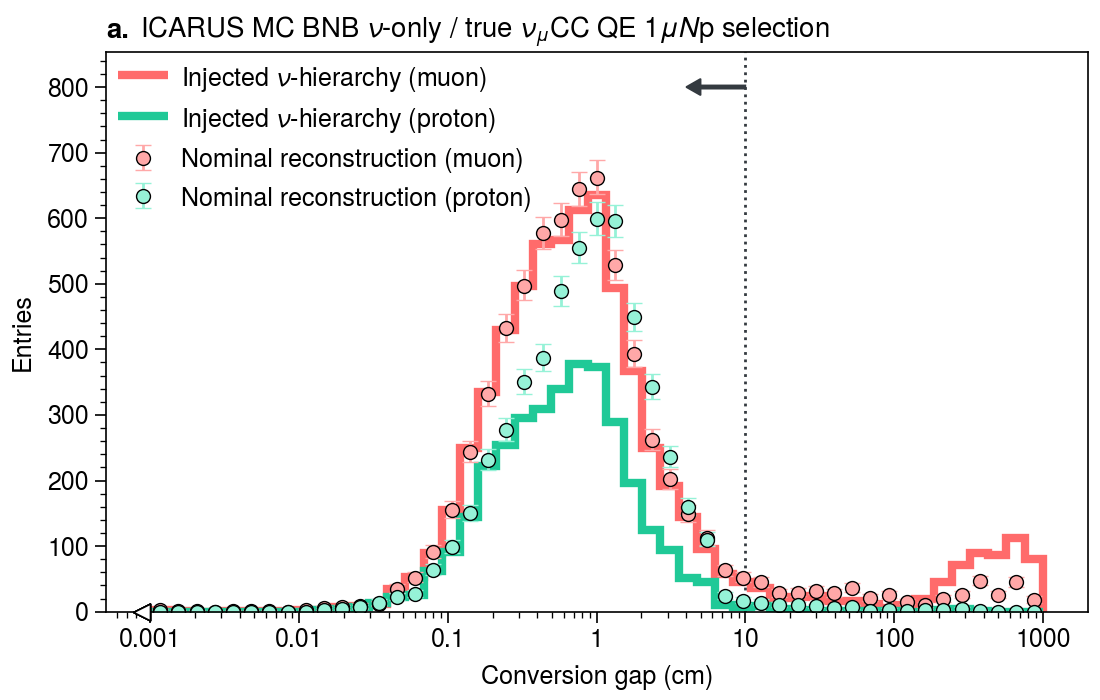

In [28]:
from hist import quick_construct

var='vtxDist'
binning=hist.axis.Variable(np.logspace(-3, 3))


fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Entries',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xlabel=r'Conversion gap (cm)',
    abc='a.', 
    # yscale='log',
    xscale='log'
)

(A,B), _ = CCNp_muonAna.get(['nominal', 'cheated_nuH'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_nuH', var, binning)
hep.histplot(A, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_nuH']} (muon)')
# ax[0].format(urtitle='Muons')

(A,B), _ = CCNp_protonAna.get(['nominal', 'cheated_nuH'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_nuH', var, binning)
hep.histplot(A, ax=ax[0], color='teal2', histtype='errorbar', label=f'{loader_formatted['nominal']} (proton)', mec='k', markeredgewidth=0.5)
hep.histplot(B, yerr=False, ax=ax[0], color='teal5', lw=3, label=f'{loader_formatted['cheated_nuH']} (proton)')
# ax[0].format(urtitle='Protons')

ax.axvline(10, lw=1, ls=':', color='gray8', zorder=-99)
ax.arrow(10, 800, -5, 0, color='gray8', width=5, head_width=25, head_length=1)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ul', order='F')




## Track score

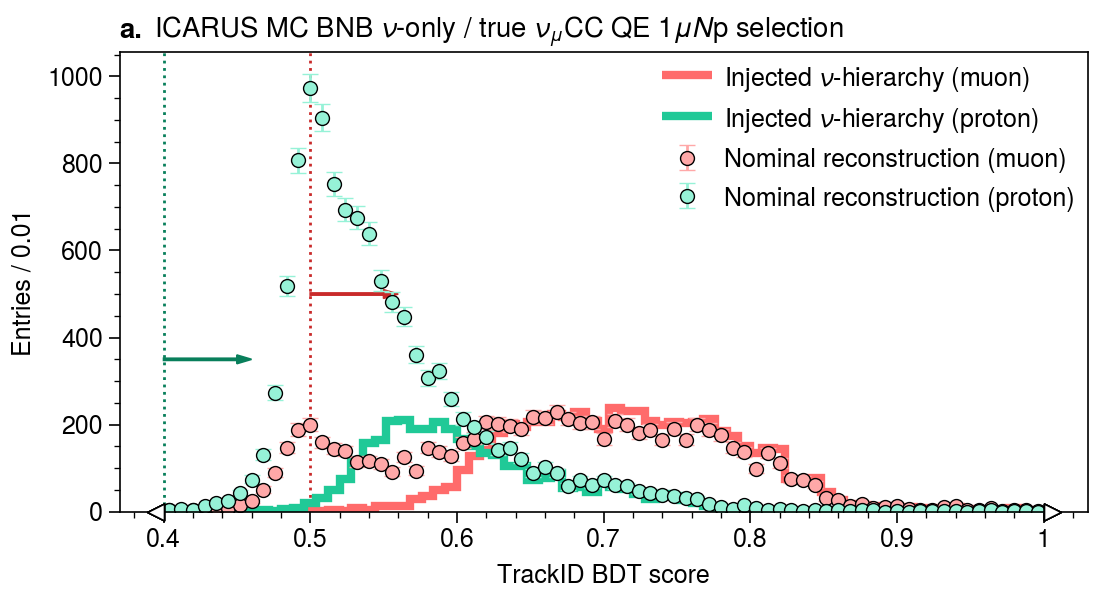

In [29]:

var='trackScore'
binning=hist.axis.Regular(75, 0.4, 1)

fig, ax = plot.subplots(
    width=5.5, height=3, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'TrackID BDT score',
    abc='a.', 
    # yscale='log'
)

(A,B), _ = CCNp_muonAna.get(['nominal', 'cheated_nuH'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_nuH', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_nuH']} (muon)')


(A,B), _ = CCNp_protonAna.get(['nominal', 'cheated_nuH'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_nuH', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=f'{loader_formatted['nominal']} (proton)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=f'{loader_formatted['cheated_nuH']} (proton)')


ax.axvline(0.5, lw=1, ls=':', color='red9', zorder=-99)
ax.arrow(0.5, 500, 0.05, 0, color='red9', width=5, head_width=20, head_length=0.01)

ax.axvline(0.4, lw=1, ls=':', color='teal9', zorder=-99)
ax.arrow(0.4, 350, 0.05, 0, color='teal9', width=5, head_width=20, head_length=0.01)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ur', order='F')

## Muon track length

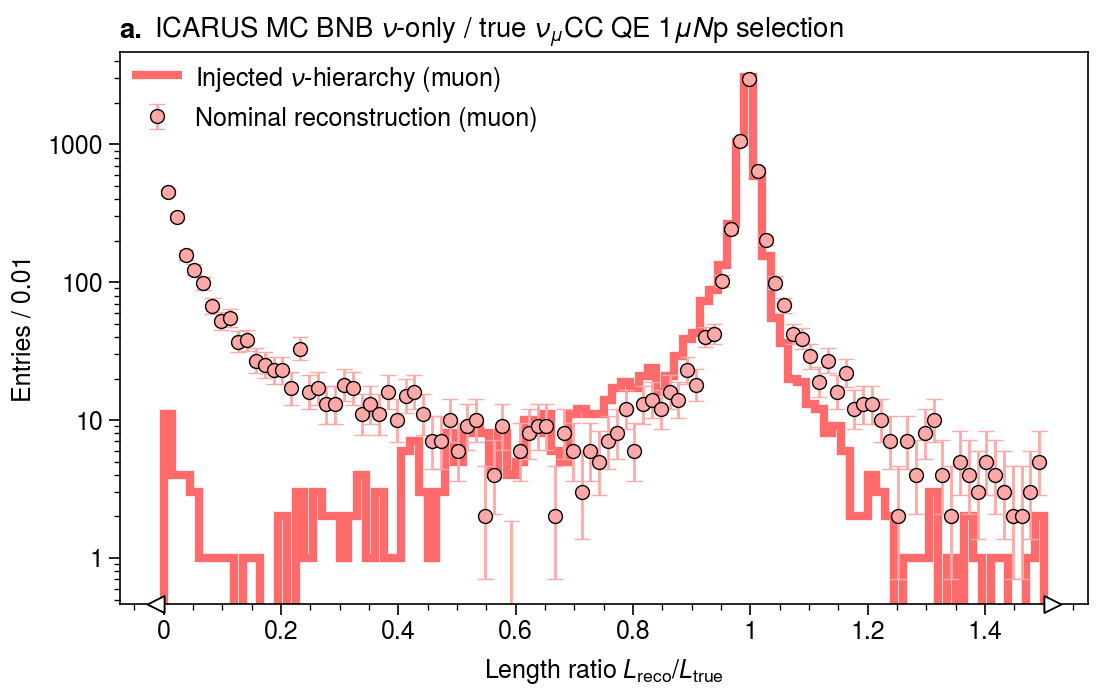

In [30]:
var='length_ratio'
binning=hist.axis.Regular(100, 0, 1.5)

fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'Length ratio $L_\mathrm{reco}/L_\mathrm{true}$',
    abc='a.', 
    yscale='log'
)

(A,B), _ = CCNp_muonAna.get(['nominal', 'cheated_nuH'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_nuH', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_nuH']} (muon)')
# ax[0].format(urtitle='Muons')

# ax.axvline(30, lw=1, ls=':', color='red9', zorder=-99)
# ax.arrow(30, 1000, -10, 0, color='red9', width=65, head_width=300, head_length=1)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ul', order='F')

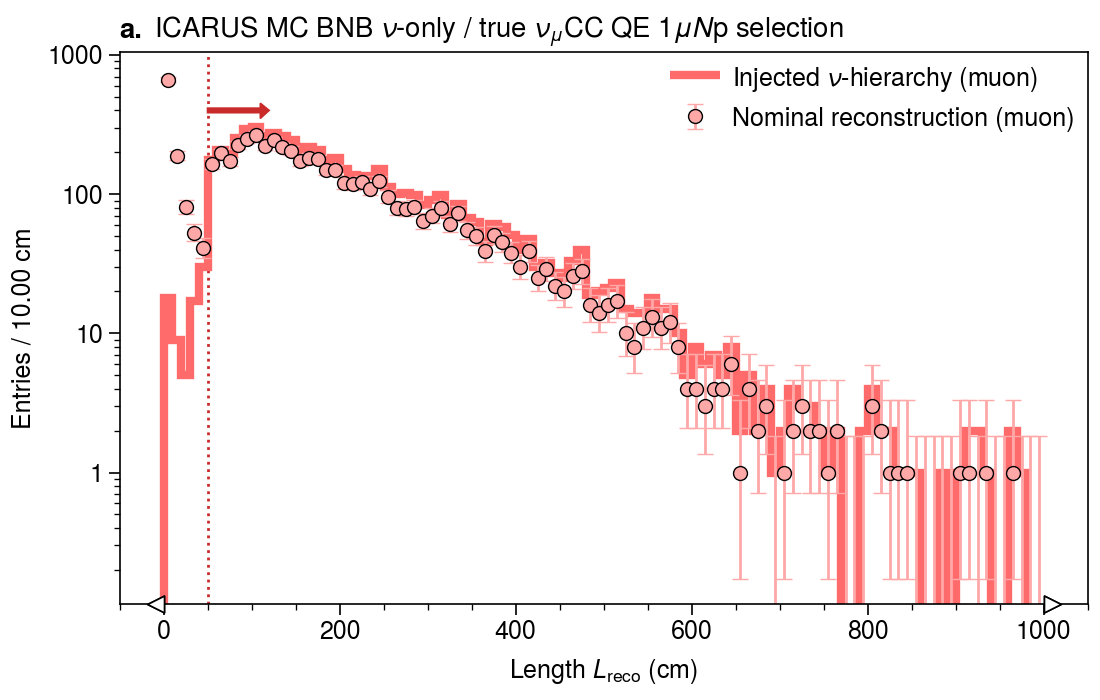

In [31]:
var='length'
binning=hist.axis.Regular(100, 0, 1000)

fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f} cm',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'Length $L_\mathrm{reco}$ (cm)',
    abc='a.', 
    yscale='log'
)

(A,B), _ = CCNp_muonAna.get(['nominal', 'cheated_nuH'], var, binning)
A0, _ = CCNp_muonAna.get('nominal', var, binning)
B0, _ = CCNp_muonAna.get('cheated_nuH', var, binning)
hep.histplot(A, ax=ax[0], color='red3', histtype='errorbar', label=f'{loader_formatted['nominal']} (muon)', mec='k', markeredgewidth=0.5)
hep.histplot(B, yerr=False, ax=ax[0], color='red5', lw=3, label=f'{loader_formatted['cheated_nuH']} (muon)')

ax.axvline(50, lw=1, ls=':', color='red9', zorder=-99)
ax.arrow(50, 400, 60, 0, color='red9', width=30, head_width=100, head_length=10)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ur', order='F')

## Proton deposited energy

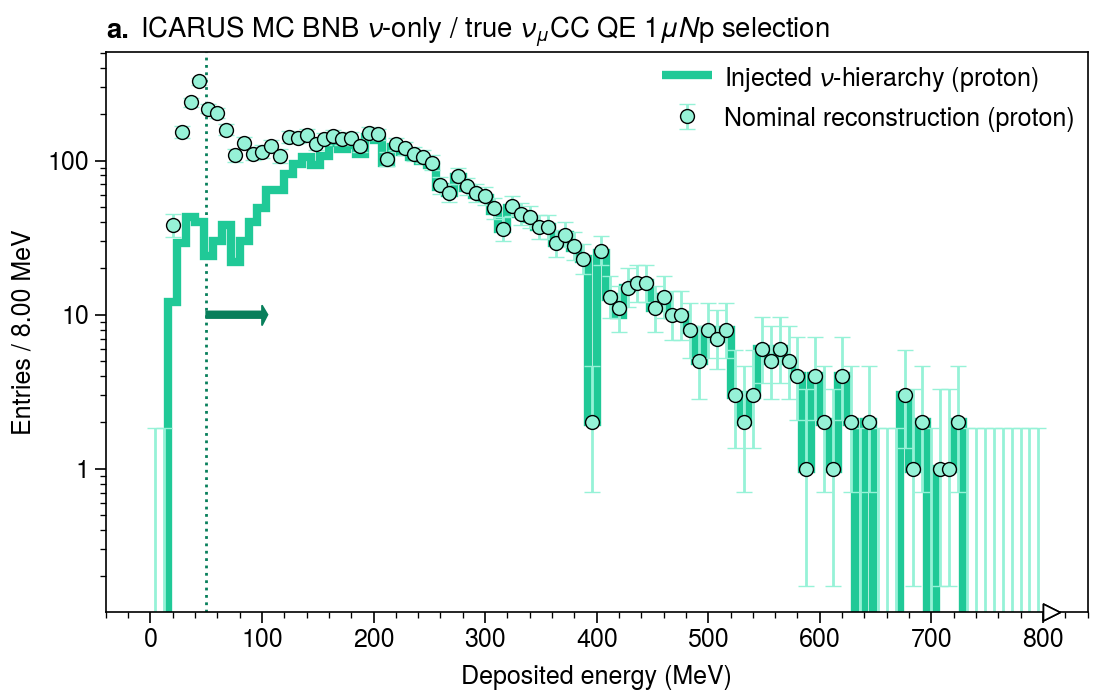

In [32]:
var='depEnergy'
binning=hist.axis.Regular(100, 0, 800)
# binning=hist.axis.Variable(np.logspace(1, 3, 100))

fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f} MeV',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'Deposited energy (MeV)',
    abc='a.', 
    yscale='log',
    # xscale='log'
)
(A,B), _ = CCNp_protonAna.get(['nominal', 'cheated_nuH'], var, binning)
A0, _ = CCNp_protonAna.get('nominal', var, binning)
B0, _ = CCNp_protonAna.get('cheated_nuH', var, binning)
hep.histplot(A, ax=ax[0], color='teal2', histtype='errorbar', label=f'{loader_formatted['nominal']} (proton)', mec='k', markeredgewidth=0.5)
hep.histplot(B, yerr=False, ax=ax[0], color='teal5', lw=3, label=f'{loader_formatted['cheated_nuH']} (proton)')

ax.axvline(50, lw=1, ls=':', color='teal9', zorder=-99)
ax.arrow(50, 10, 50, 0, color='teal9', width=1, head_width=3, head_length=5)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ur', order='F')

# $\nu$-hierarchy deficit in the LADDER, from the cuts


## Hit completeness/purity

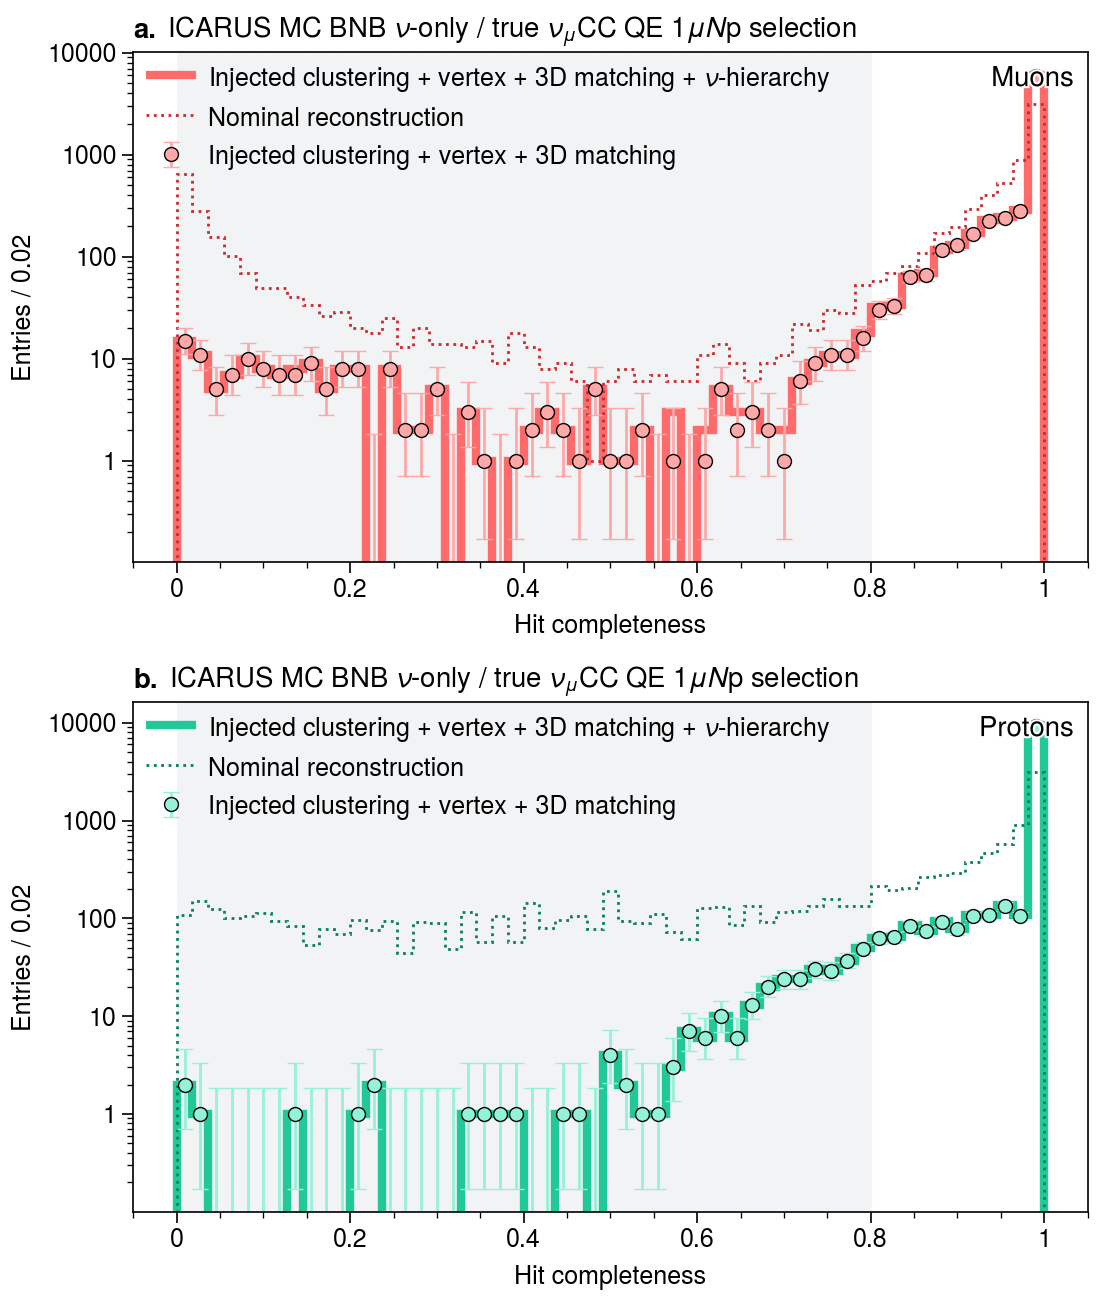

In [33]:

binning=hist.axis.Regular(55, 0, 1, flow=False)
fig, ax = plot.subplots(
    width=5.5, height=6.5, ncols=1, nrows=2, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xlabel='Hit completeness',
    abc='a.', 
    yscale='log'
)
var='completeness'

(A,B,C), _ = CCNp_muonAna.get(['cheated_2d_vtx_3d', 'cheated_2d_vtx_3d_nu', 'nominal'], var, binning)
A0, _ = CCNp_muonAna.get('cheated_2d_vtx_3d', var, binning)
B0, _ = CCNp_muonAna.get('cheated_2d_vtx_3d_nu', var, binning)
C0, _ = CCNp_muonAna.get('nominal', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=loader_formatted['cheated_2d_vtx_3d'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=loader_formatted['cheated_2d_vtx_3d_nu'])
hep.histplot(C0, yerr=False, ax=ax[0], color='red9', lw=1, ls=':', label=loader_formatted['nominal'])
ax[0].format(urtitle='Muons')

(A,B,C), _ = CCNp_protonAna.get(['cheated_2d_vtx_3d', 'cheated_2d_vtx_3d_nu', 'nominal'], var, binning)
A0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d', var, binning)
B0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d_nu', var, binning)
C0, _ = CCNp_protonAna.get('nominal', var, binning)
hep.histplot(A0, ax=ax[1], color='teal2', histtype='errorbar', label=loader_formatted['cheated_2d_vtx_3d'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[1], color='teal5', lw=3, label=loader_formatted['cheated_2d_vtx_3d_nu'])
hep.histplot(C0, yerr=False, ax=ax[1], color='teal9', lw=1, ls=':', label=loader_formatted['nominal'])
ax[1].format(urtitle='Protons')

[axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
[axi.legend(ncols=1, loc='ul') for axi in ax]


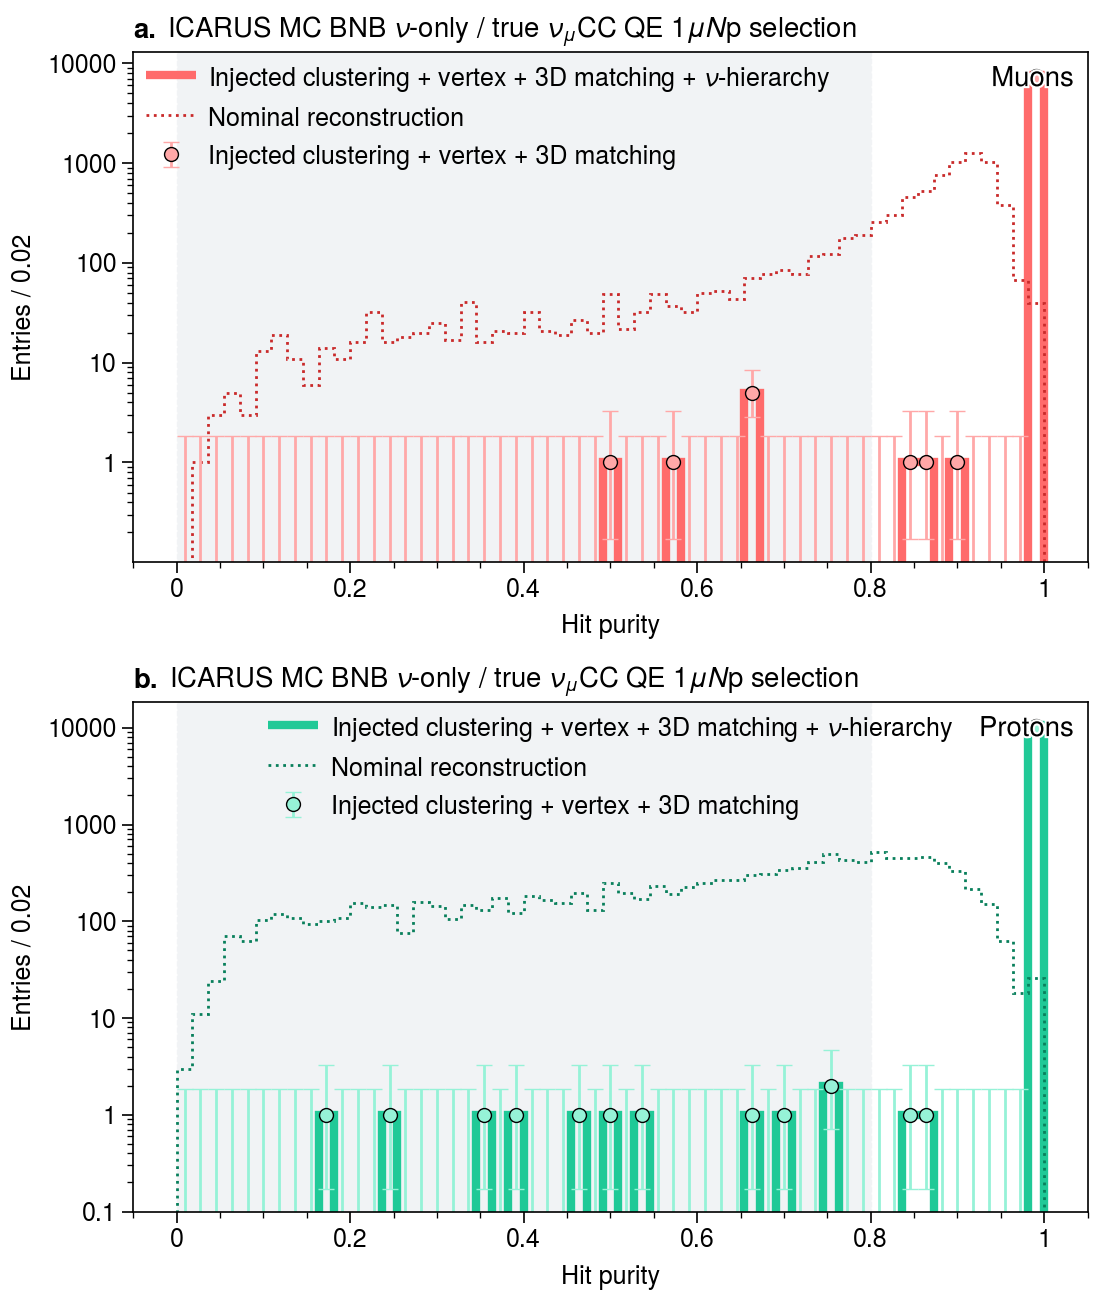

In [34]:

binning=hist.axis.Regular(55, 0, 1., flow=False)
fig, ax = plot.subplots(
    width=5.5, height=6.5, ncols=1, nrows=2, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xlabel='Hit purity',
    abc='a.', 
    yscale='log'
)

var='purity'

(A,B,C), _ = CCNp_muonAna.get(['cheated_2d_vtx_3d', 'cheated_2d_vtx_3d_nu', 'nominal'], var, binning)
A0, _ = CCNp_muonAna.get('cheated_2d_vtx_3d', var, binning)
B0, _ = CCNp_muonAna.get('cheated_2d_vtx_3d_nu', var, binning)
C0, _ = CCNp_muonAna.get('nominal', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=loader_formatted['cheated_2d_vtx_3d'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=loader_formatted['cheated_2d_vtx_3d_nu'])
hep.histplot(C0, yerr=False, ax=ax[0], color='red9', lw=1, ls=':', label=loader_formatted['nominal'])
ax[0].format(urtitle='Muons')

(A,B,C), _ = CCNp_protonAna.get(['cheated_2d_vtx_3d', 'cheated_2d_vtx_3d_nu', 'nominal'], var, binning)
A0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d', var, binning)
B0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d_nu', var, binning)
C0, _ = CCNp_protonAna.get('nominal', var, binning)
hep.histplot(A0, ax=ax[1], color='teal2', histtype='errorbar', label=loader_formatted['cheated_2d_vtx_3d'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[1], color='teal5', lw=3, label=loader_formatted['cheated_2d_vtx_3d_nu'])
hep.histplot(C0, yerr=False, ax=ax[1], color='teal9', lw=1, ls=':', label=loader_formatted['nominal'])
ax[1].format(urtitle='Protons')


[axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
[axi.legend(ncols=1) for axi in ax]

## $\chi^2$ selection variables
The muons selction requires 
- $\chi^2_\mu < 30$
- $\chi^2_p > 60$

The protons selection 
- $\chi^2_p < 100$

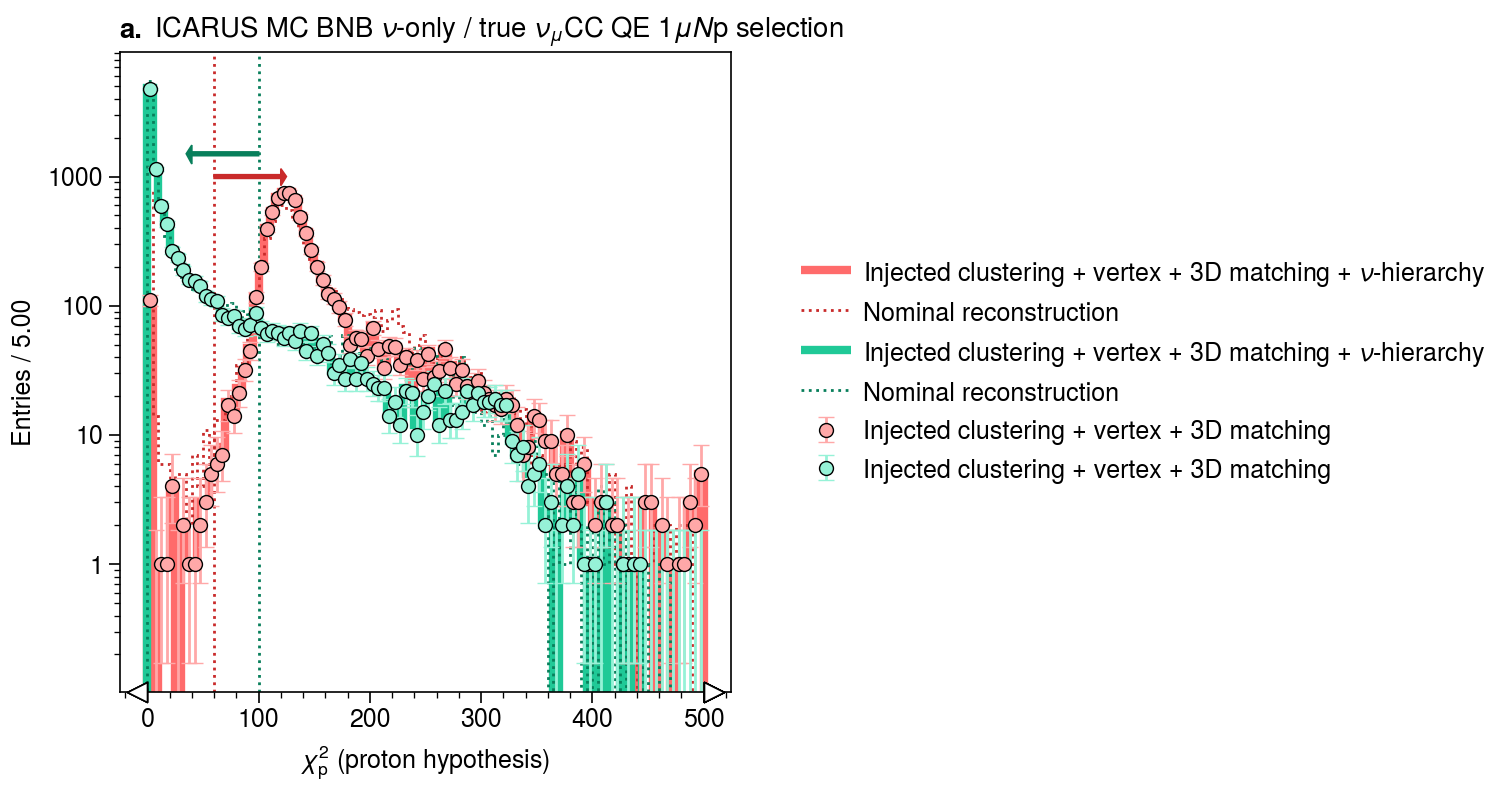

In [35]:

var='chi2_proton'
binning=hist.axis.Regular(100, 0, 500)

fig, ax = plot.subplots(
    width=7.5, height=4, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'$\chi^2_\mathrm{p}$ (proton hypothesis)',
    abc='a.', 
    yscale='log'
)

(A,B,C), _ = CCNp_muonAna.get(['cheated_2d_vtx_3d', 'cheated_2d_vtx_3d_nu', 'nominal'], var, binning)
A0, _ = CCNp_muonAna.get('cheated_2d_vtx_3d', var, binning)
B0, _ = CCNp_muonAna.get('cheated_2d_vtx_3d_nu', var, binning)
C0, _ = CCNp_muonAna.get('nominal', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=loader_formatted['cheated_2d_vtx_3d'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=loader_formatted['cheated_2d_vtx_3d_nu'])
hep.histplot(C0, yerr=False, ax=ax[0], color='red9', lw=1, ls=':', label=loader_formatted['nominal'])

(A,B,C), _ = CCNp_protonAna.get(['cheated_2d_vtx_3d', 'cheated_2d_vtx_3d_nu', 'nominal'], var, binning)
A0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d', var, binning)
B0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d_nu', var, binning)
C0, _ = CCNp_protonAna.get('nominal', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=loader_formatted['cheated_2d_vtx_3d'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=loader_formatted['cheated_2d_vtx_3d_nu'])
hep.histplot(C0, yerr=False, ax=ax[0], color='teal9', lw=1, ls=':', label=loader_formatted['nominal'])


ax.axvline(60, lw=1, ls=':', color='red9', zorder=-99)
ax.arrow(60, 1000, 60, 0, color='red9', width=65, head_width=300, head_length=5)
ax.axvline(100, lw=1, ls=':', color='teal9', zorder=-99)
ax.arrow(100, 1500, -60, 0, color='teal9', width=100, head_width=500, head_length=5)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='r', order='F')

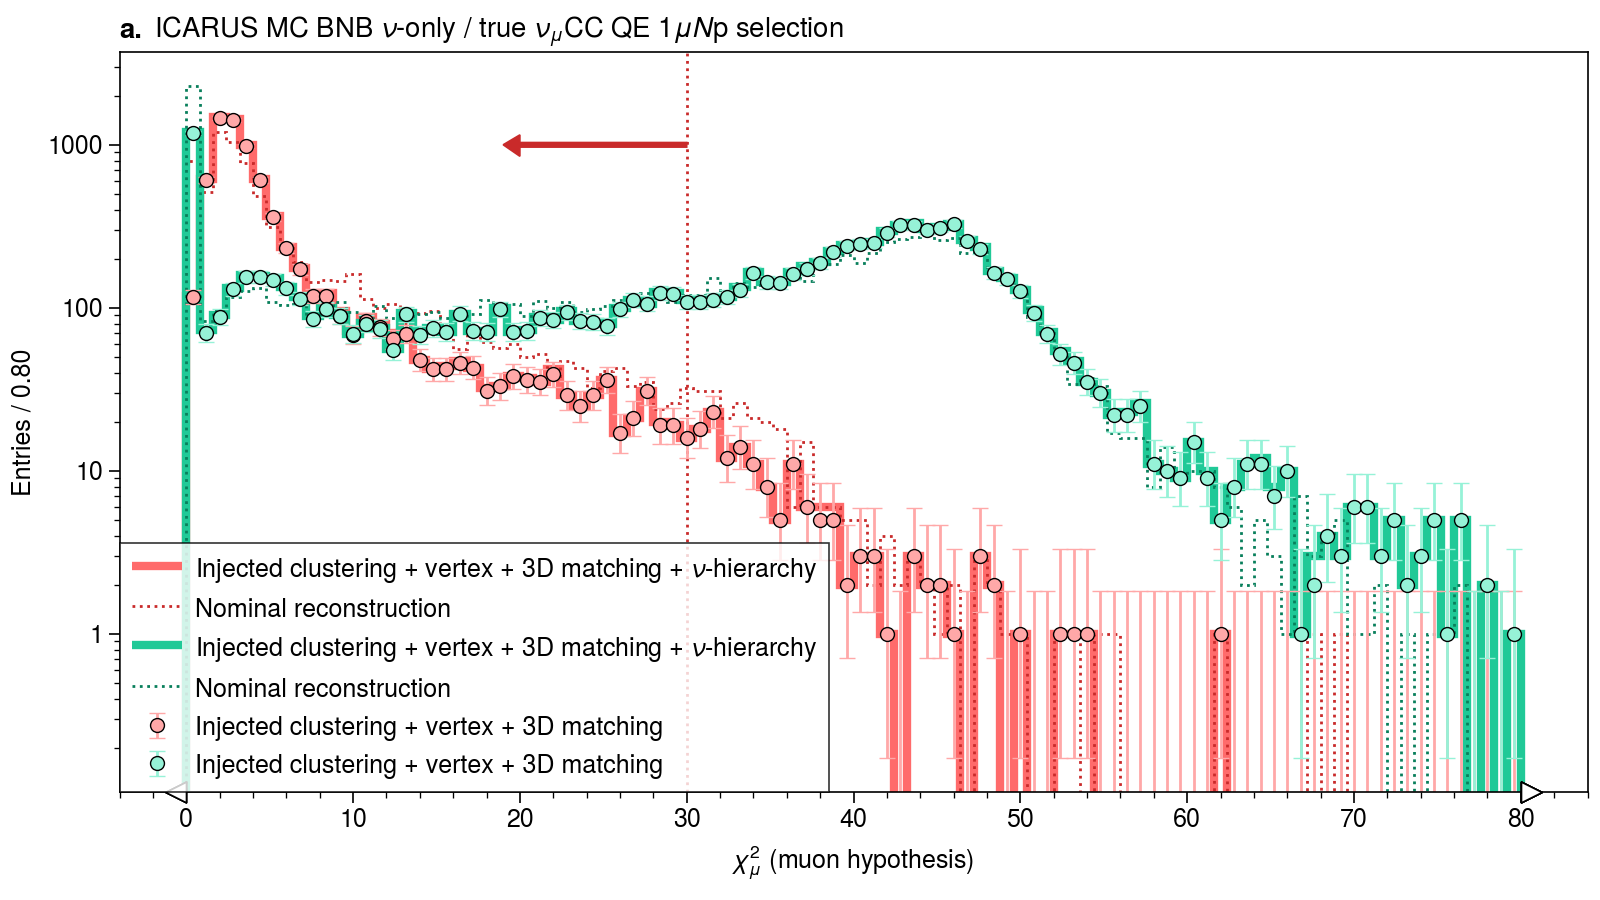

In [36]:
var='chi2_mu'
binning=hist.axis.Regular(100, 0, 80)

fig, ax = plot.subplots(
    width=8, height=4.5, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'$\chi^2_\mu$ (muon hypothesis)',
    abc='a.', 
    yscale='log'
)

(A,B,C), _ = CCNp_muonAna.get(['cheated_2d_vtx_3d', 'cheated_2d_vtx_3d_nu', 'nominal'], var, binning)
A0, _ = CCNp_muonAna.get('cheated_2d_vtx_3d', var, binning)
B0, _ = CCNp_muonAna.get('cheated_2d_vtx_3d_nu', var, binning)
C0, _ = CCNp_muonAna.get('nominal', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=loader_formatted['cheated_2d_vtx_3d'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=loader_formatted['cheated_2d_vtx_3d_nu'])
hep.histplot(C0, yerr=False, ax=ax[0], color='red9', lw=1, ls=':', label=loader_formatted['nominal'])


(A,B,C), _ = CCNp_protonAna.get(['cheated_2d_vtx_3d', 'cheated_2d_vtx_3d_nu', 'nominal'], var, binning)
A0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d', var, binning)
B0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d_nu', var, binning)
C0, _ = CCNp_protonAna.get('nominal', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=loader_formatted['cheated_2d_vtx_3d'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=loader_formatted['cheated_2d_vtx_3d_nu'])
hep.histplot(C0, yerr=False, ax=ax[0], color='teal9', lw=1, ls=':', label=loader_formatted['nominal'])

ax.axvline(30, lw=1, ls=':', color='red9', zorder=-99)
ax.arrow(30, 1000, -10, 0, color='red9', width=65, head_width=300, head_length=1)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ll', order='F', frameon=True)

## Vertex distance

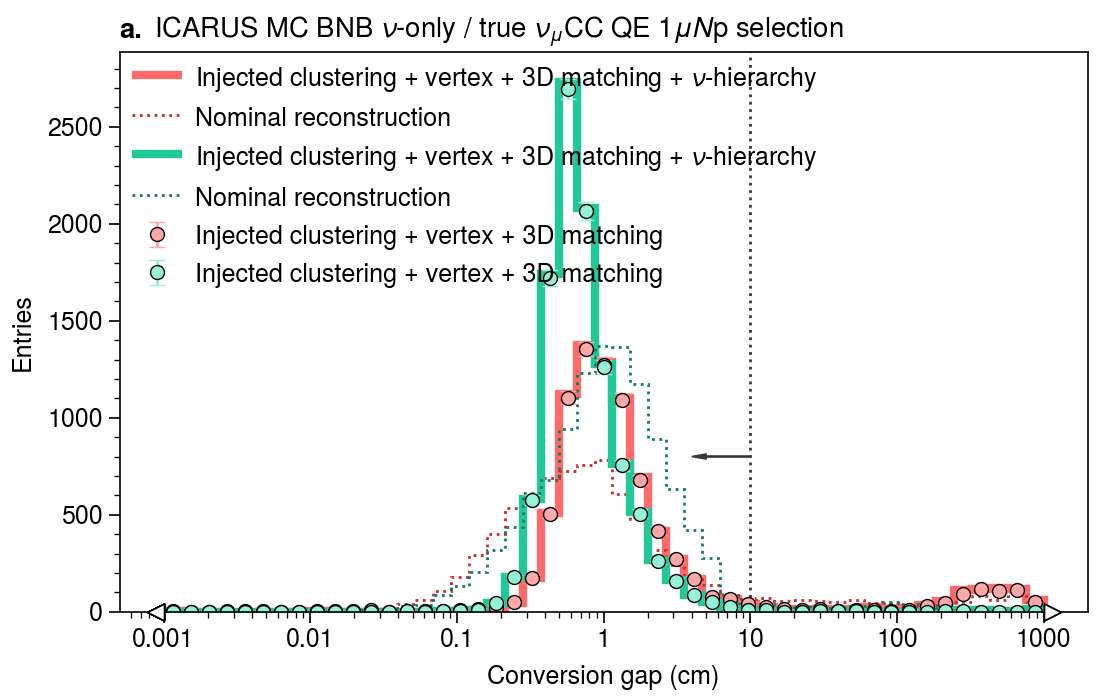

In [37]:
from hist import quick_construct

var='vtxDist'
binning=hist.axis.Variable(np.logspace(-3, 3))


fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Entries',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xlabel=r'Conversion gap (cm)',
    abc='a.', 
    # yscale='log',
    xscale='log'
)

(A,B,C), _ = CCNp_muonAna.get(['cheated_2d_vtx_3d', 'cheated_2d_vtx_3d_nu', 'nominal'], var, binning)
A0, _ = CCNp_muonAna.get('cheated_2d_vtx_3d', var, binning)
B0, _ = CCNp_muonAna.get('cheated_2d_vtx_3d_nu', var, binning)
C0, _ = CCNp_muonAna.get('nominal', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=loader_formatted['cheated_2d_vtx_3d'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=loader_formatted['cheated_2d_vtx_3d_nu'])
hep.histplot(C0, yerr=False, ax=ax[0], color='red9', lw=1, ls=':', label=loader_formatted['nominal'])


(A,B,C), _ = CCNp_protonAna.get(['cheated_2d_vtx_3d', 'cheated_2d_vtx_3d_nu', 'nominal'], var, binning)
A0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d', var, binning)
B0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d_nu', var, binning)
C0, _ = CCNp_protonAna.get('nominal', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=loader_formatted['cheated_2d_vtx_3d'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=loader_formatted['cheated_2d_vtx_3d_nu'])
hep.histplot(C0, yerr=False, ax=ax[0], color='teal9', lw=1, ls=':', label=loader_formatted['nominal'])

ax.axvline(10, lw=1, ls=':', color='gray8', zorder=-99)
ax.arrow(10, 800, -5, 0, color='gray8', width=5, head_width=25, head_length=1)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ul', order='F')


## Track score

/Users/msotgia/dev_areas/py_envs/pandora_ana_env/lib/python3.13/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


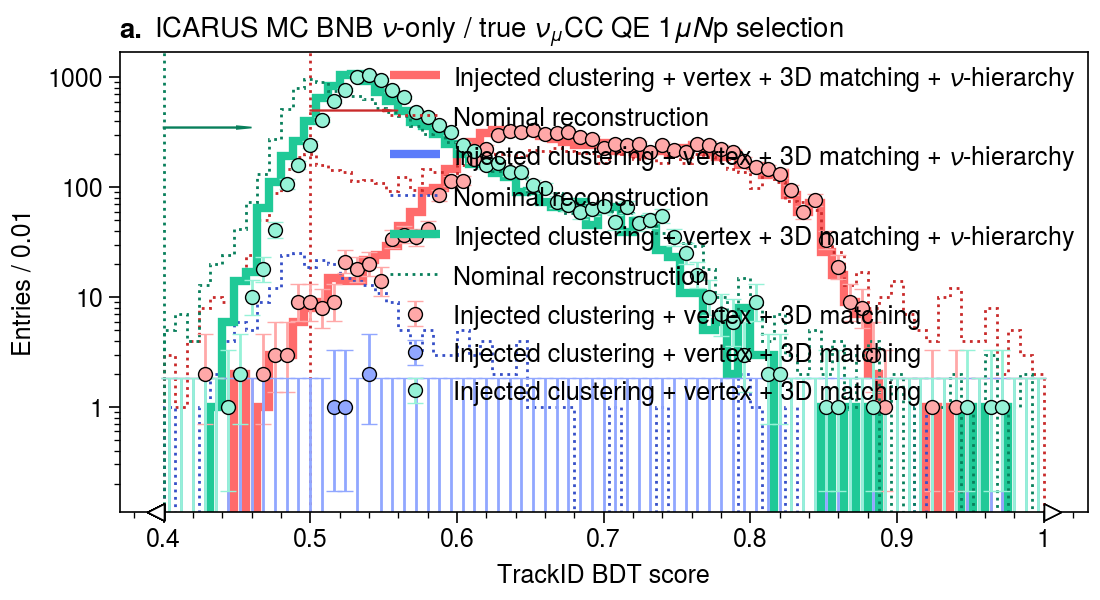

In [38]:

var='trackScore'
binning=hist.axis.Regular(75, 0.4, 1)

fig, ax = plot.subplots(
    width=5.5, height=3, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'TrackID BDT score',
    abc='a.', 
    yscale='log'
)

(A,B,C), _ = CCNp_muonAna.get(['cheated_2d_vtx_3d', 'cheated_2d_vtx_3d_nu', 'nominal'], var, binning)
A0, _ = CCNp_muonAna.get('cheated_2d_vtx_3d', var, binning)
B0, _ = CCNp_muonAna.get('cheated_2d_vtx_3d_nu', var, binning)
C0, _ = CCNp_muonAna.get('nominal', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=loader_formatted['cheated_2d_vtx_3d'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=loader_formatted['cheated_2d_vtx_3d_nu'])
hep.histplot(C0, yerr=False, ax=ax[0], color='red9', lw=1, ls=':', label=loader_formatted['nominal'])

(A,B,C), _ = CCNp_protonAna.get(['cheated_2d_vtx_3d', 'cheated_2d_vtx_3d_nu', 'nominal'], var, binning)
A0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d', var, binning, conditions={'pandoraPrimary': 0})
B0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d_nu', var, binning, conditions={'pandoraPrimary': 0})
C0, _ = CCNp_protonAna.get('nominal', var, binning, conditions={'pandoraPrimary': 0})
hep.histplot(A0, ax=ax[0], color='indigo3', histtype='errorbar', label=loader_formatted['cheated_2d_vtx_3d'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='indigo5', lw=3, label=loader_formatted['cheated_2d_vtx_3d_nu'])
hep.histplot(C0, yerr=False, ax=ax[0], color='indigo9', lw=1, ls=':', label=loader_formatted['nominal'])


(A,B,C), _ = CCNp_protonAna.get(['cheated_2d_vtx_3d', 'cheated_2d_vtx_3d_nu', 'nominal'], var, binning)
A0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d', var, binning)
B0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d_nu', var, binning)
C0, _ = CCNp_protonAna.get('nominal', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=loader_formatted['cheated_2d_vtx_3d'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=loader_formatted['cheated_2d_vtx_3d_nu'])
hep.histplot(C0, yerr=False, ax=ax[0], color='teal9', lw=1, ls=':', label=loader_formatted['nominal'])

ax.axvline(0.5, lw=1, ls=':', color='red9', zorder=-99)
ax.arrow(0.5, 500, 0.05, 0, color='red9', width=5, head_width=20, head_length=0.01)

ax.axvline(0.4, lw=1, ls=':', color='teal9', zorder=-99)
ax.arrow(0.4, 350, 0.05, 0, color='teal9', width=5, head_width=20, head_length=0.01)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ur', order='F')

## Muon track length

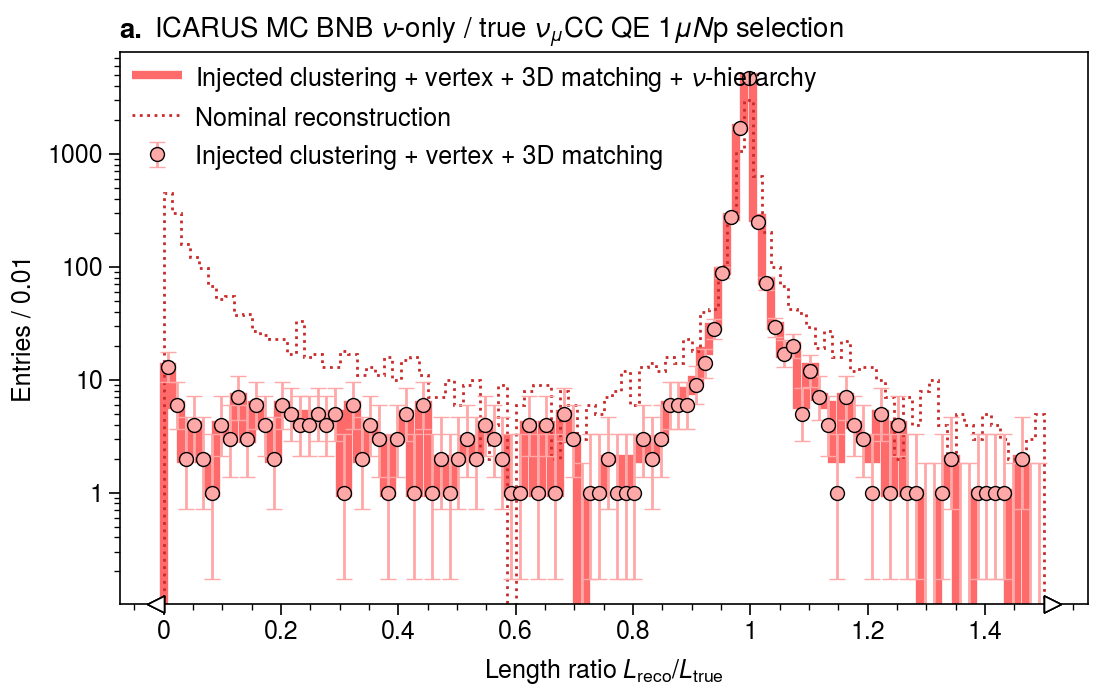

In [39]:
var='length_ratio'
binning=hist.axis.Regular(100, 0, 1.5)

fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f}',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'Length ratio $L_\mathrm{reco}/L_\mathrm{true}$',
    abc='a.', 
    yscale='log'
)

(A,B,C), _ = CCNp_muonAna.get(['cheated_2d_vtx_3d', 'cheated_2d_vtx_3d_nu', 'nominal'], var, binning)
A0, _ = CCNp_muonAna.get('cheated_2d_vtx_3d', var, binning)
B0, _ = CCNp_muonAna.get('cheated_2d_vtx_3d_nu', var, binning)
C0, _ = CCNp_muonAna.get('nominal', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=loader_formatted['cheated_2d_vtx_3d'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=loader_formatted['cheated_2d_vtx_3d_nu'])
hep.histplot(C0, yerr=False, ax=ax[0], color='red9', lw=1, ls=':', label=loader_formatted['nominal'])

# ax.axvline(30, lw=1, ls=':', color='red9', zorder=-99)
# ax.arrow(30, 1000, -10, 0, color='red9', width=65, head_width=300, head_length=1)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ul', order='F')

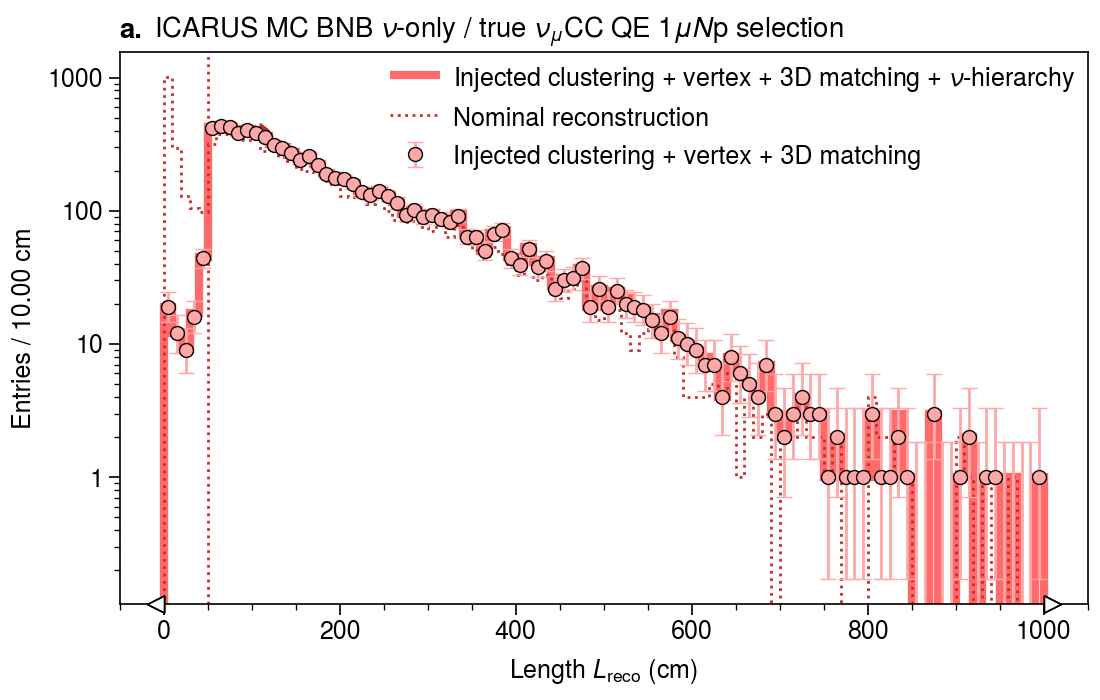

In [40]:
var='length'
binning=hist.axis.Regular(100, 0, 1000)

fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f} cm',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'Length $L_\mathrm{reco}$ (cm)',
    abc='a.', 
    yscale='log'
)

(A,B,C), _ = CCNp_muonAna.get(['cheated_2d_vtx_3d', 'cheated_2d_vtx_3d_nu', 'nominal'], var, binning)
A0, _ = CCNp_muonAna.get('cheated_2d_vtx_3d', var, binning)
B0, _ = CCNp_muonAna.get('cheated_2d_vtx_3d_nu', var, binning)
C0, _ = CCNp_muonAna.get('nominal', var, binning)
hep.histplot(A0, ax=ax[0], color='red3', histtype='errorbar', label=loader_formatted['cheated_2d_vtx_3d'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='red5', lw=3, label=loader_formatted['cheated_2d_vtx_3d_nu'])
hep.histplot(C0, yerr=False, ax=ax[0], color='red9', lw=1, ls=':', label=loader_formatted['nominal'])

ax.axvline(50, lw=1, ls=':', color='red9', zorder=-99)
ax.arrow(50, 400, 60, 0, color='red9', width=30, head_width=100, head_length=10)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ur', order='F')

## Proton deposited energy

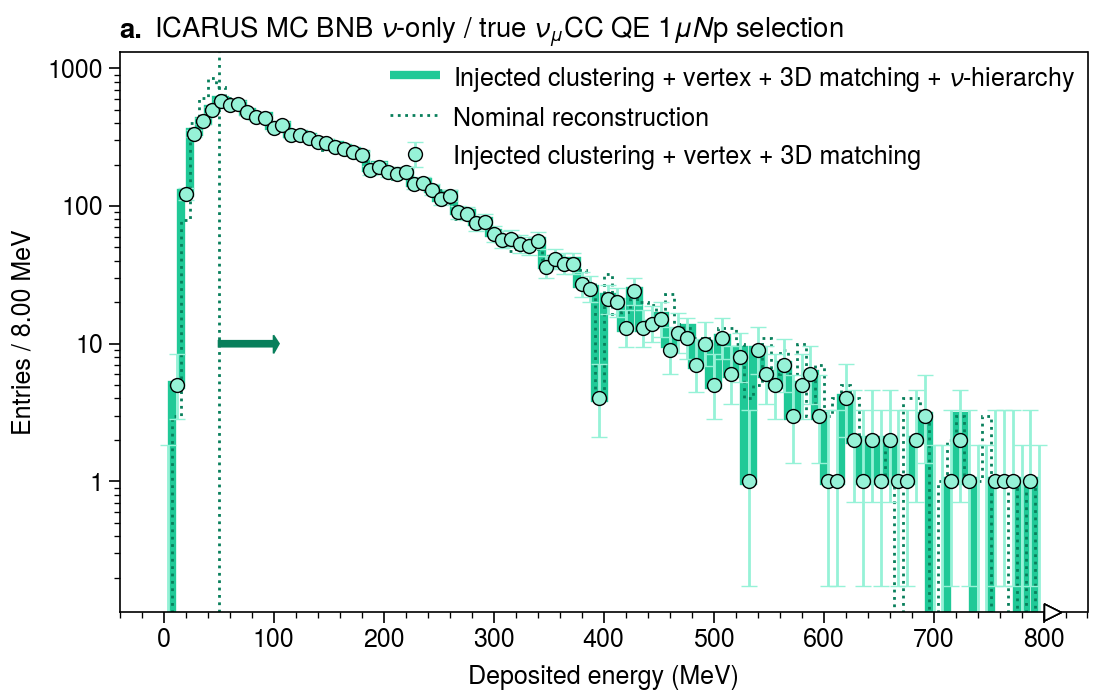

In [41]:
var='depEnergy'
binning=hist.axis.Regular(100, 0, 800)
# binning=hist.axis.Variable(np.logspace(1, 3, 100))

fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f} MeV',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'Deposited energy (MeV)',
    abc='a.', 
    yscale='log',
    # xscale='log'
)

(A,B,C), _ = CCNp_protonAna.get(['cheated_2d_vtx_3d', 'cheated_2d_vtx_3d_nu', 'nominal'], var, binning)
A0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d', var, binning)
B0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d_nu', var, binning)
C0, _ = CCNp_protonAna.get('nominal', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=loader_formatted['cheated_2d_vtx_3d'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=loader_formatted['cheated_2d_vtx_3d_nu'])
hep.histplot(C0, yerr=False, ax=ax[0], color='teal9', lw=1, ls=':', label=loader_formatted['nominal'])

ax.axvline(50, lw=1, ls=':', color='teal9', zorder=-99)
ax.arrow(50, 10, 50, 0, color='teal9', width=1, head_width=3, head_length=5)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ur', order='F')

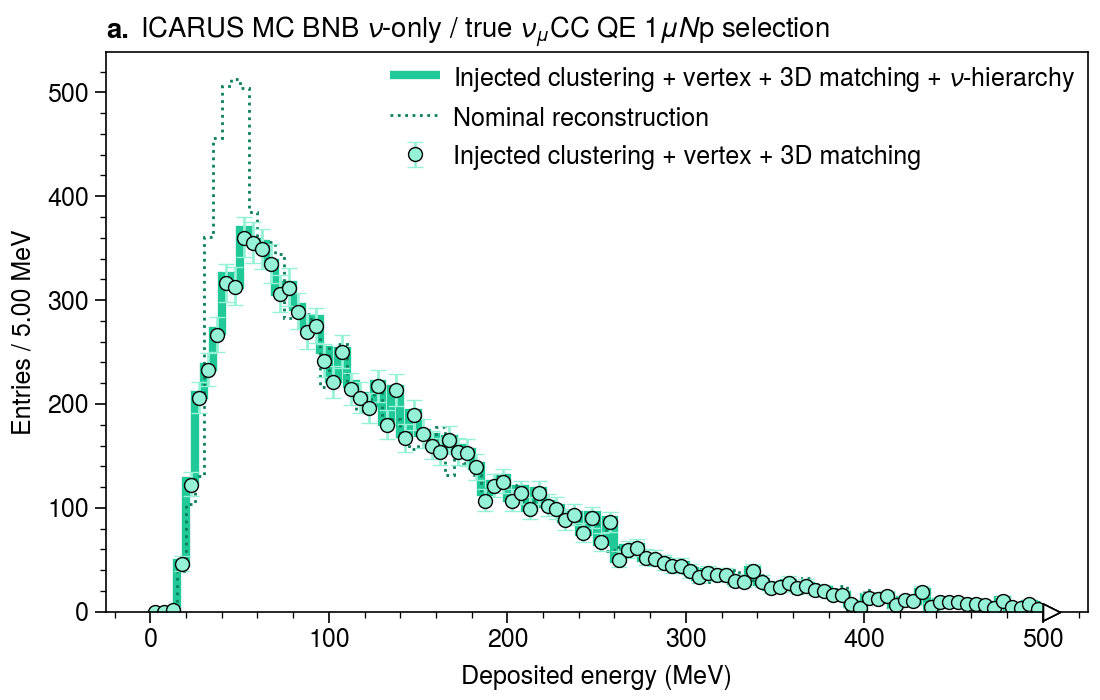

In [60]:
var='depEnergy'
binning=hist.axis.Regular(100, 0, 500)
# binning=hist.axis.Variable(np.logspace(1, 3, 100))

fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Entries / {binning.widths[0]:.2f} MeV',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    # ultitle='Work in progress',
    xlabel=r'Deposited energy (MeV)',
    abc='a.', 
    # yscale='log',
    # xscale='log'
)

(A,B,C), _ = CCNp_protonAna.get(['cheated_2d_vtx_3d', 'cheated_2d_vtx_3d_nu', 'nominal'], var, binning)
A0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d', var, binning)
B0, _ = CCNp_protonAna.get('cheated_2d_vtx_3d_nu', var, binning)
C0, _ = CCNp_protonAna.get('nominal', var, binning)
hep.histplot(A0, ax=ax[0], color='teal2', histtype='errorbar', label=loader_formatted['cheated_2d_vtx_3d'], mec='k', markeredgewidth=0.5)
hep.histplot(B0, yerr=False, ax=ax[0], color='teal5', lw=3, label=loader_formatted['cheated_2d_vtx_3d_nu'])
hep.histplot(C0, yerr=False, ax=ax[0], color='teal9', lw=1, ls=':', label=loader_formatted['nominal'])

# ax.axvline(50, lw=1, ls=':', color='teal9', zorder=-99)
# ax.arrow(50, 10, 50, 0, color='teal9', width=1, head_width=3, head_length=5)

# [axi.axvspan(0, 0.8, lw=0.5, ls='--', color='gray1', zorder=-99) for axi in ax]
ax.legend(ncols=1, loc='ur', order='F')

In [43]:
CCNp_protonAna.tree_base

'true_{}'

In [44]:
h, _ = CCNp_protonAna.get(['cheated_nuH', 'nominal'], 'length', hist.axis.Variable(np.logspace(-.5, 2, 10)))

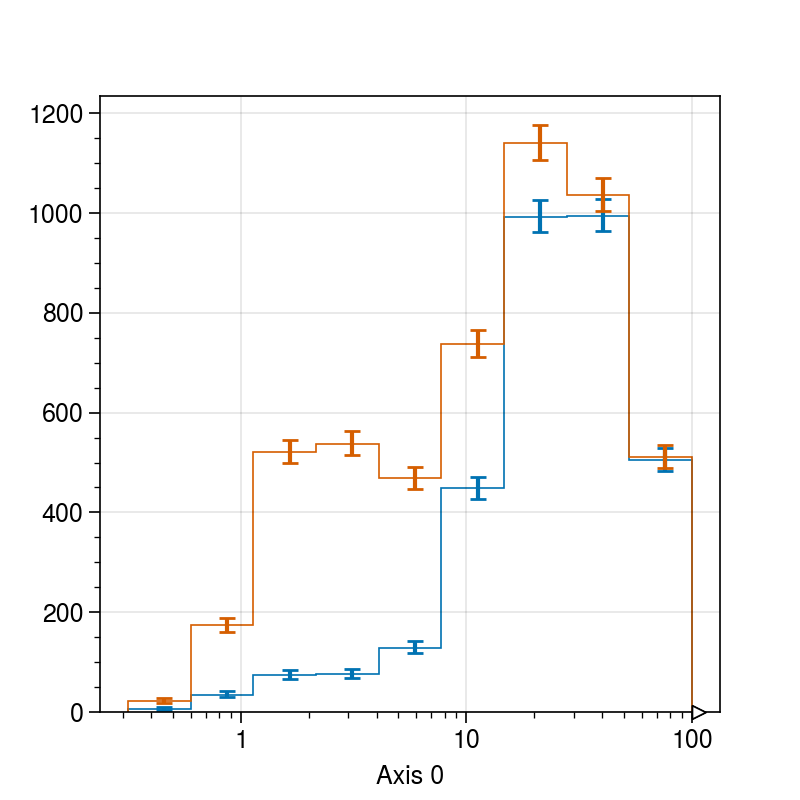

In [45]:
h[0].plot()
h[1].plot()
plt.xscale('log')

In [46]:
np.logspace(-.5, 2, 10)

array([  0.31622777,   0.59948425,   1.13646367,   2.15443469,
         4.08423865,   7.74263683,  14.67799268,  27.82559402,
        52.74997064, 100.        ])

In [48]:
dir(CCNp_muonAna), CCNp_protonAna

(['__class__',
  '__delattr__',
  '__dict__',
  '__dir__',
  '__doc__',
  '__eq__',
  '__firstlineno__',
  '__format__',
  '__ge__',
  '__getattribute__',
  '__getstate__',
  '__gt__',
  '__hash__',
  '__init__',
  '__init_subclass__',
  '__le__',
  '__lt__',
  '__module__',
  '__ne__',
  '__new__',
  '__reduce__',
  '__reduce_ex__',
  '__repr__',
  '__setattr__',
  '__sizeof__',
  '__static_attributes__',
  '__str__',
  '__subclasshook__',
  '__weakref__',
  'data',
  'get',
  'keys',
  'tree_base'],
 <__main__.Component at 0x117217890>)

In [49]:
CCNp_protonAna.keys('nominal')

['chi2_mu',
 'chi2_proton',
 'length',
 'length_ratio',
 'vtxDist',
 'trackScore',
 'completeness',
 'purity',
 'depEnergy',
 'pandoraPrimary',
 'Run',
 'Subrun',
 'Evt']

In [64]:
CCNp_protonAna.get('nominal', 'Run', hist.axis.Regular(100, 0, 5))[0][0]

Hist(Regular(100, 0, 5, label='Axis 0'), storage=Double()) # Sum: 11315.0